# N.B.

After this notebook, we will switch back to Julia language.
The reasons are threefold:

* Julia provides a decent performance boost for free;
* Julia is the main language at LakeTide, technical support has neither distance nor latency;
* Julia has better support for OpenStreetMap, which is needed for future traffic simulation.

Switching from Julia to Python was not a bad idea per se;
Python plus Networkx worked quite well in the last two weeks as
the tool set to conduct the proof of concepts; currently, new
needs demand new set of tools.

# Heads-Up

In this notebook, we scale up the graph to 1000 nodes;
this makes the size of samples around one billion, which
makes it impossible to be generated and further augmented.

The way to cope with that is to randomly sample pairs of nodes
and generate training data from them. Idealy, the training size
before augmentation is around one millon.

The meaning of this stocastic manner is twofold.
* it reduced the complexity of training set generation massively
* this is a decent test to see if the model is truly able to generalize

# Problems

The algorithm does not seem to work well with a graph
of 1000 nodes, which is somehow disappointing.

Possible reasons are the following:

* The model is not powerful enough to learn the graph;
* The stochastic sampling of training data does not show the model the big picture, i.e.,
the model gets confused by the edges it has never seen before;

* The training sample should allow the model the take steps back, i.e., for each sample
path, the parent nodes should be included;

However, after deeper analysis, we tend to believe that it is certain properties of 
the graph that make the current model much harder to be trained and to infer. ("./Mar_19/")

# Make it "smarter" TODO

* Detect dead loop;
* <del>Include the parent nodes for training</del> (**tests show that this makes the model harder to be trained and less "intelligent"**)
* Randomize the input vectors during inference
* Add a new heuristic, i.e., for each first order edge, 
look ahead a certain number of steps and use a greedy
strategy to always go with the edge with the largest centrality;
(adding the last node might help, geo-location, cos-distance, Euclidean-distance etc.)

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import mxnet as mx
import logging
from sklearn.metrics import accuracy_score
from utils import plot_g, load_model

In [2]:
NUM_NODE = 100
WEIGHT_MIN = .5
WEIGHT_MAX = 1.

In [3]:
def calc_euclidean_dist(G, tmp_node, node):
    
    p_1 = np.array([G.nodes[tmp_node]['x'], G.nodes[tmp_node]['y']])
    p_2 = np.array([G.nodes[node]['x'], G.nodes[node]['y']])
    return np.sqrt(np.sum((p_1 - p_2)**2))

def generate_low_degree_g(num_nodes=100,\
                          min_out_degree=2,\
                          max_out_degree=4,\
                          weight_min=WEIGHT_MIN,\
                          weight_max=WEIGHT_MAX,\
                          grid_size=20000):
    
    G = nx.Graph()
    
    euclidean_coords = np.linspace(0.0, 1.0, num=grid_size, endpoint=False)
    coords_indices = list(range(grid_size))
    
    random.shuffle(coords_indices)
    x_coords = euclidean_coords[coords_indices][:num_nodes]
#     print(x_coords)
    random.shuffle(coords_indices)
    y_coords = euclidean_coords[coords_indices][:num_nodes]
#     print(y_coords)
    
    # Add coordinates to nodes
    for node, coord in enumerate(zip(x_coords, y_coords)):
#         print(node, coord[0], coord[1])
        G.add_node(node, x=coord[0], y=coord[1])
    
    for node in G.nodes:
        
        tmp_nodes = list(G.nodes)
        tmp_nodes.remove(node)
        node_dist = map(lambda tmp_node: (tmp_node, calc_euclidean_dist(G, tmp_node, node)), tmp_nodes)
        node_dist = sorted(node_dist, key=lambda d:d[1])
        
        num_of_neighbors = random.randint(min_out_degree, max_out_degree)
#         print(node, out_neighbors)
        
#         G.add_edges_from(map(lambda d:(node, d), out_neighbors))
        
        for tmp_node in node_dist:

            if G.degree(tmp_node[0]) >= max_out_degree \
                or G.degree(node) >= num_of_neighbors:
                # This node has maximum number of neighbors already
                continue
            
            weight = random.uniform(weight_min, weight_max)
            geo_dist = calc_euclidean_dist(G, tmp_node[0], node)
            
            G.add_edge(node, tmp_node[0], weight=weight * geo_dist)
    
    # Add centrality to edges
    edge_centrality = nx.edge_betweenness_centrality(G, \
                                                     k=G.number_of_nodes(), \
                                                     weight='weight')
    assert len(edge_centrality) == G.number_of_edges()
    
    for edge_data in G.edges.data():
        edge_data[2]['centrality'] = edge_centrality[(edge_data[0], edge_data[1])]
        
    return G

4
2
100
176


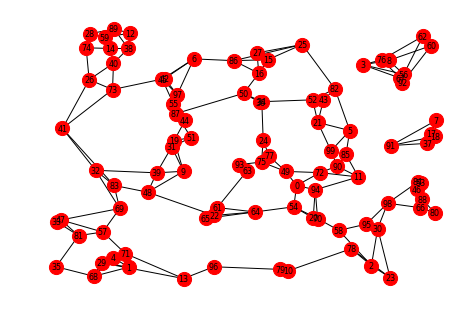

In [4]:
# G = nx.read_gpickle("./Mar_19/graph.pickle")

G = generate_low_degree_g()
max_degree = max(G.degree, key=lambda d: d[1])[1]
min_degree = min(G.degree, key=lambda d: d[1])[1]
print(max_degree)
print(min_degree)
print(G.number_of_nodes())
print(G.number_of_edges())

plot_g(G, with_labels=True, node_size=200, font_size=8)

In [5]:
from networkx import NetworkXNoPath

def calc_cosine_dist(p1, p2):
    return np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))

def find_central_edge_greedy(G, start, depth=3):
    
    cur_node = start
    path = [cur_node]
    
    centrality_sum = 0.0
    
    for d in range(depth + 1):
        
        edge_tuples = map(lambda e:(e[0], e[1], G.get_edge_data(e[0], e[1])['centrality']),\
                  G.edges(cur_node))
        
#         print(cur_node)
#         print(edge_tuples)
#         print('')
        chosen_edge = max(edge_tuples, key=lambda t:t[2])
        
        assert cur_node == chosen_edge[0]
        cur_node = chosen_edge[1]
        
        # No point of getting trapped
        # in a dead loop;
        # just break out
        if cur_node in path:
            break
        
        centrality_sum += chosen_edge[2]
        path.append(cur_node)
    
    return centrality_sum

def encode_edges(G, parent, node, src, dst):
    
    ret = np.zeros((max_degree, 7))
    ret[:, -1] = -1
    
    x_dst = G.nodes[dst]['x']
    y_dst = G.nodes[dst]['y']
    x_src = G.nodes[src]['x']
    y_src = G.nodes[src]['y']
    
    for idx, edge in enumerate(G.edges(node)):
        u = edge[0]
        v = edge[1]
        
        # Only look forward
        # allow look backwards(shouldn't be included)
        if v == parent:
            continue
        
        ret[idx][0] = G.get_edge_data(u, v)['centrality']
        ret[idx][1] = G.get_edge_data(u, v)['weight']
        
        x_u = G.nodes[u]['x']
        y_u = G.nodes[u]['y']
        x_v = G.nodes[v]['x']
        y_v = G.nodes[v]['y']

        ret[idx][2] = calc_cosine_dist((x_v-x_u, y_v-y_u), (x_dst-x_u, y_dst-y_u))
        ret[idx][3] = calc_euclidean_dist(G, v, dst)
        ret[idx][4] = x_v
        ret[idx][5] = y_v
        ret[idx][-1] = v
        
    return (ret, x_src, y_src, x_dst, y_dst)

def generate_stochastic_dataset(G, num_train_node_pairs=400,\
                                    num_test_node_pairs=100, verbose_frequence=100):
    
    train_features = []
    train_labels = []
    test_features = []
    test_labels = []
    
    pair_path_dict = dict()
    
    train_selected_pairs = []
    test_selected_pairs = []
    num_of_nodes = G.number_of_nodes()
    
    train_mode = True
    
    while True:
        src = np.random.randint(0, num_of_nodes)
        dst = np.random.randint(0, num_of_nodes)
        
        if src == dst:
            continue
        
        if (src, dst) in pair_path_dict:
            continue
        
        try:
            shortest_path = nx.dijkstra_path(G, src, dst)
                
        except NetworkXNoPath:
#                 print("No path between %d and %d" % (src, dst))
            continue
    
        for path in [shortest_path, shortest_path[::-1]]:
            
            src = path[0]
            dst = path[-1]
            
            pair_path_dict[(src, dst)] = path
            
            if train_mode and len(train_selected_pairs) < num_train_node_pairs:
                train_selected_pairs.append((src, dst))
            else:
                train_mode = False
                if len(test_selected_pairs) < num_test_node_pairs:
                    test_selected_pairs.append((src, dst))
                    
            parent_node = -1
            cur_node = src
            for mid_node in path[1:]:

#                 print('parent:(%d), X:(%d, %d), y:(%d)' % (parent_node, cur_node, dst, mid_node))
                if train_mode:
                    train_features.append(encode_edges(G, parent_node, cur_node, src, dst))
                    train_labels.append(mid_node)
                else:
                    test_features.append(encode_edges(G, parent_node, cur_node, src, dst))
                    test_labels.append(mid_node)
                
                parent_node = cur_node
                cur_node = mid_node
                
#                 sample_cnt += 1
                
#                 if sample_cnt % frequent == 0:
#                     print("Collected %d samples." % (sample_cnt))
        
#         print('len of train_selected_pairs: %d' % len(train_selected_pairs))
#         print('len of test_selected_pairs: %d' % len(test_selected_pairs))
        if len(train_selected_pairs) >= num_train_node_pairs \
            and len(test_selected_pairs) >= num_test_node_pairs:
            break
        
    return train_features, train_labels, test_features, test_labels, train_selected_pairs, test_selected_pairs, pair_path_dict

In [6]:
def find_label_idx(feature, label):
    
    for idx, row in enumerate(feature):
        if label == row[-1]:
            break
    
    return idx

def augment_dataset(X, y, augmentation=False, augmentation_index=20, print_freq=300000):
    
    sample_size = len(y)
    augmented_sample_size = augmentation_index * sample_size
    feature_size = 28
    
    X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)
    indices = np.arange(max_degree)
    
    cnt = 0
    for feature, label in zip(X, y):
        for _ in range(augmentation_index):
            
            if augmentation:
                np.random.shuffle(indices)
            
            feature_tmp = feature[0][indices]
            label_tmp = find_label_idx(feature_tmp, label)
            
            X_aug[cnt] = np.append(feature_tmp[:, :-1].reshape(-1), [feature[1], feature[2], feature[3], feature[4]])
            y_aug[cnt] = label_tmp
            
            cnt += 1
            
#             if cnt % print_freq == 0:
#                 print("Processed %d samples" % (cnt))
            
    return X_aug, y_aug

In [15]:
def generate_samples_from_graph(num_node_pairs, graph_size=100, augmentation=False, augmentation_index=1, label='Train'):
    
    G = generate_low_degree_g(num_nodes=graph_size)
    
#     plot_g(G, with_labels=True, node_size=200, font_size=8)
    
    features, labels, _, _, selected_pairs, _, pair_path_dict =\
            generate_stochastic_dataset(G, num_train_node_pairs=num_node_pairs, num_test_node_pairs=0)
        
    X, y = augment_dataset(features, labels,\
                           augmentation=augmentation,
                           augmentation_index=augmentation_index, \
                           print_freq=600)
    
    assert len(features) == len(labels)
#     assert len(y) == len(labels)
    assert len(X) == len(y)
    
    print(label)
    print("%d pairs are selected for training" % (len(selected_pairs)))
    print("len of pair_path_dict: %d" % (len(pair_path_dict)))
    print("Num of training sample: %d" % len(y))
    print(label)
    print('\n')
    
    return X, y, G, pair_path_dict

In [16]:
X_train, y_train, G_train, _ = generate_samples_from_graph(num_node_pairs=2000, augmentation=True, augmentation_index=10, label='Train')
X_val, y_val, G_val, _ = generate_samples_from_graph(num_node_pairs=200, augmentation=False, label='Validation')

Train
2000 pairs are selected for training
len of pair_path_dict: 2000
Num of training sample: 182680
Train


Validation
200 pairs are selected for training
len of pair_path_dict: 200
Num of training sample: 2074
Validation




In [17]:
batch_size = 128

train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(X_val, y_val, batch_size=batch_size)

In [63]:
def build_model(context=mx.gpu()):
    
    data = mx.sym.var('data')
    label = mx.sym.var('softmax_label')
    
    fc1  = mx.sym.FullyConnected(data=data, num_hidden=2048)
    fc1 = mx.sym.Activation(data=fc1, act_type="relu")
    fc1 = mx.sym.Dropout(data=fc1)
    
    fc2  = mx.sym.FullyConnected(data=fc1, num_hidden=1024)
    fc2 = mx.sym.Activation(data=fc2, act_type="relu")
    fc2 = mx.sym.Dropout(data=fc2)
    
    fc3  = mx.sym.FullyConnected(data=fc2, num_hidden=max_degree)
    mlp  = mx.sym.SoftmaxOutput(data=fc3, label=label)
    
    return mx.mod.Module(symbol=mlp, context=context)

In [118]:
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout
model = build_model()
model.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
model.init_params()

In [ ]:
model.fit(train_iter,  # train data
              eval_data=val_iter,  # validation data
              optimizer='adam',  # use SGD to train
#               optimizer_params={'learning_rate':0.01, 'momentum': 0.9},
              eval_metric='acc',  # report accuracy during training
              batch_end_callback = mx.callback.Speedometer(batch_size, 200),
#               epoch_end_callback = mx.callback.do_checkpoint("mymodel", 1),
              num_epoch=50) 

# We test the model on node pairs sampled from new graph

In [26]:
model = load_model("mymodel", 10, train_iter, context=mx.gpu())

In [27]:
X_test, y_test, G_test, _ = generate_samples_from_graph(num_node_pairs=200, graph_size=200, augmentation=False, augmentation_index=1, label='Test')
pred_test = np.argmax(model.predict(mx.io.NDArrayIter(X_test, y_test, batch_size=128)).asnumpy(), axis=1)
acc = accuracy_score(y_test, pred_test)
print("Accuracy on test set: %f" % (acc))

Test
200 pairs are selected for training
len of pair_path_dict: 200
Num of training sample: 2608
Test


Accuracy on test set: 0.891488


In [241]:
graph_sizes = [100, 500, 1000]
stats = [[] for _ in range(len(graph_sizes))]
sample_size_stats = [[] for _ in range(len(graph_sizes))]
number_of_tests = 100
num_node_pairs = 400

In [242]:
for idx, num_nodes in enumerate(graph_sizes):
    
    print('Working on graphs with %d nodes' % num_nodes)
    for i in range(number_of_tests):
        
        if i > 0 and i % 5 == 0:
            print("Processed %d graphs" % i)
            
        X_test, y_test, G_test, _ = generate_samples_from_graph(num_node_pairs=num_node_pairs, graph_size=num_nodes, augmentation=False, label='Test')

        pred_test = np.argmax(model.predict(mx.io.NDArrayIter(X_test, y_test)).asnumpy(), axis=1)
        acc = accuracy_score(y_test, pred_test)
        stats[idx].append(acc)
        sample_size_stats[idx].append(len(y_test))

Working on graphs with 100 nodes
Processed 5 graphs
Processed 10 graphs
Processed 15 graphs
Processed 20 graphs
Processed 25 graphs
Processed 30 graphs
Processed 35 graphs
Processed 40 graphs
Processed 45 graphs
Processed 50 graphs
Processed 55 graphs
Processed 60 graphs
Processed 65 graphs
Processed 70 graphs
Processed 75 graphs
Processed 80 graphs
Processed 85 graphs
Processed 90 graphs
Processed 95 graphs
Working on graphs with 500 nodes
Processed 5 graphs
Processed 10 graphs
Processed 15 graphs
Processed 20 graphs
Processed 25 graphs
Processed 30 graphs
Processed 35 graphs
Processed 40 graphs
Processed 45 graphs
Processed 50 graphs
Processed 55 graphs
Processed 60 graphs
Processed 65 graphs
Processed 70 graphs
Processed 75 graphs
Processed 80 graphs
Processed 85 graphs
Processed 90 graphs
Processed 95 graphs
Working on graphs with 1000 nodes
Processed 5 graphs
Processed 10 graphs
Processed 15 graphs
Processed 20 graphs
Processed 25 graphs
Processed 30 graphs
Processed 35 graphs
Pro

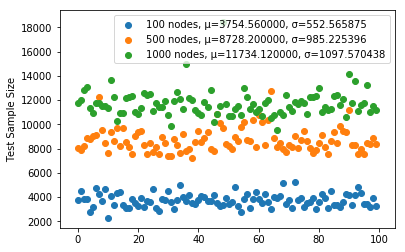

In [243]:
for idx, stat in enumerate(sample_size_stats):
    stat_mean = np.mean(stat)
    stat_std = np.std(stat)
    label = u'%d nodes, μ=%f, σ=%f' % \
            (graph_sizes[idx], stat_mean, stat_std)
    plt.scatter(list(range(number_of_tests)), stat, label=label)

plt.ylabel("Test Sample Size")
plt.legend(loc='best')
plt.show()

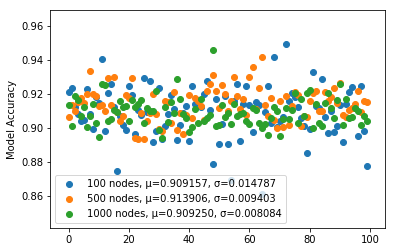

In [244]:
for idx, stat in enumerate(stats):
    stat_mean = np.mean(stat)
    stat_std = np.std(stat)
    label = u'%d nodes, μ=%f, σ=%f' % \
            (graph_sizes[idx], stat_mean, stat_std)
    plt.scatter(list(range(number_of_tests)), stat, label=label)

plt.ylabel("Model Accuracy")
plt.legend(loc='best')
plt.show()

# We evaluate the paths generated by the model

In [28]:
def nn_infer_next_node(G, path, parent, cur_node, src, dst, model):
#     print("In nn_infer_next_node")
    input_vec, x_src, y_src, x_dst, y_dst = encode_edges(G, parent, cur_node, src, dst)
    
    real_input_vec = np.append(input_vec[:, :-1].reshape(-1), [x_src, y_src, x_dst, y_dst])
    pred = model.predict(mx.io.NDArrayIter(np.array([real_input_vec]), np.array([0]))).asnumpy()[0]
    pred_idx = np.argmax(pred)
    neighbor = int(input_vec[pred_idx][-1])
    
    if neighbor == -1:
#         print("Invalid prediction, randomizing next node")
        avaliable_neighbors = filter(lambda d: d >= 0, input_vec[:, -1])
        neighbor = int(avaliable_neighbors[np.random.randint(0, len(avaliable_neighbors))])
    
#     if neighbor in path:
#         print("Duplicated nodes, randomizing next node")
#         avaliable_neighbors = filter(lambda d: d >= 0 and d != neighbor, input_vec[:, -1])

#         if len(avaliable_neighbors) == 0:
#             print("Duplicated nodes, no other nodes available")
#         else:
#             neighbor = int(avaliable_neighbors[np.random.randint(0, len(avaliable_neighbors))])
        
    return (neighbor, G.get_edge_data(cur_node, neighbor)['weight'])

def dijkstra_path_finder(G, src, dst, p=0.0, model=None, invalid_path_threshold=G.number_of_nodes()):
    
    path = [src]
    parent_node = -1
    cur_node = src
    total_weights = .0
    
    while True:
        
        if len(path) >= invalid_path_threshold:
            return path, total_weights, False
        
        neigbors = list(G.neighbors(cur_node))
        num_neighbors = len(neigbors)
        
        pred_next_node, _ = nn_infer_next_node(G, path, parent_node, cur_node, src, dst, model)
        pred_next_idx = neigbors.index(pred_next_node)
        
        sample_probabilities = [p/(num_neighbors-1)\
                                for _ in range(num_neighbors)]
        sample_probabilities[pred_next_idx] = 1-p
        assert sum(sample_probabilities) <= 1.0
        
        next_node = np.random.choice(neigbors, 1, p=sample_probabilities)[0]
        total_weights += G.get_edge_data(cur_node, next_node)['weight']
        path.append(next_node)
        
        if next_node == dst:
            return path, total_weights, True
        
        parent_node = cur_node
        cur_node = next_node

In [29]:
def calc_path_weight_sum(G, path):
    
    weight_sum = 0.0
    
    for idx, node in enumerate(path[:-1]):
        weight_sum += G.edges[(node, path[idx + 1])]['weight']
        
    return weight_sum

In [30]:
def calc_statistics(G, pair_path_dict, num_to_test=100):
    found_cnt = 0
    opt_path_cnt = 0
    edge_efficiency = {}
    time_efficiency = {}
    
    def calc_dot_dist(p1, p2):
        return np.dot(p1, p2)

    def calc_geo_dist(p1, p2):

        p_1 = np.array(p1)
        p_2 = np.array(p2)

        return np.sqrt(np.sum((p_1 - p_2)**2))
    
    pairs = pair_path_dict.keys()
    random.shuffle(pairs)
    
    for src, dst in pairs[:num_to_test]:

        nn_path, _, found = dijkstra_path_finder(G, src, dst, model=model, invalid_path_threshold=G.number_of_nodes())
        
        dijkstra_path = pair_path_dict[(src, dst)]
        
        if not found:
            
#             print("The model is unable to find a path between %d and %d" % (src, dst))
            
#             plot_dijkstra_nn_comparison(G, dijkstra_path, nn_path)
            
#             print("Dijkstra path :", dijkstra_path)
# #             print("NN path :", nn_path)
#             print('')
            continue

        found_cnt += 1
        
        edge_efficiency[(src, dst)] = float(len(dijkstra_path)-1) / (len(nn_path)-1)
        time_efficiency[(src, dst)] = calc_path_weight_sum(G, dijkstra_path) \
                                        / calc_path_weight_sum(G, nn_path)
        
        if nn_path == dijkstra_path:
            opt_path_cnt = opt_path_cnt + 1

        else:
            print("The model is able to find a different path between %d and %d" % (src, dst))
            plot_dijkstra_nn_comparison(G, dijkstra_path, nn_path)
            print("Dijkstra path :", dijkstra_path)
            print("NN path :", nn_path)
            print('')

    return found_cnt, opt_path_cnt, edge_efficiency, time_efficiency

In [31]:
def print_paths_statistics(G, pair_path_dict, num_to_test=100):

    num_total_path = num_to_test

    found_cnt, opt_path_cnt, edge_efficiency, time_efficiency = calc_statistics(G, pair_path_dict=pair_path_dict, num_to_test=num_to_test)
    print('%d out of %d can find path: %f' % (found_cnt, num_total_path, float(found_cnt)/num_total_path))
    print('%d out of %d can find optimal path: %f' % (opt_path_cnt, found_cnt, float(opt_path_cnt)/found_cnt))
    print('%d out of %d all paths can find optimal paths: %f' % (opt_path_cnt, num_total_path, float(opt_path_cnt)/num_total_path))
    
    edge_efficiency_values = edge_efficiency.values()
    stat_mean = np.mean(edge_efficiency_values)
    stat_std = np.std(edge_efficiency_values)
    
    label = u'%d pairs, μ=%f, σ=%f' % \
            (len(edge_efficiency), stat_mean, stat_std)
    print(label)
    
    time_efficiency_values = time_efficiency.values()
    stat_mean = np.mean(time_efficiency_values)
    stat_std = np.std(time_efficiency_values)
    
    label = u'%d pairs, μ=%f, σ=%f' % \
            (len(time_efficiency), stat_mean, stat_std)
    print(label)

Test
400 pairs are selected for training
len of pair_path_dict: 400
Num of training sample: 3430
Test


The model is able to find a different path between 79 and 71


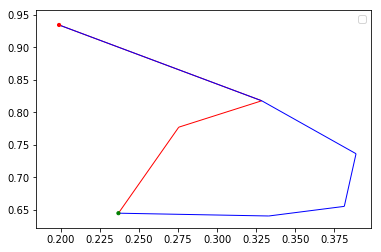

('Dijkstra path :', [79, 69, 59, 71])
('NN path :', [79, 69, 41, 98, 30, 71])

The model is able to find a different path between 92 and 72


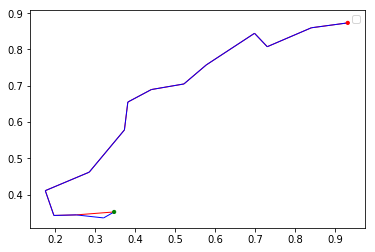

('Dijkstra path :', [92, 9, 81, 82, 80, 61, 6, 98, 38, 91, 20, 42, 14, 72])
('NN path :', [92, 9, 81, 82, 80, 61, 6, 98, 38, 91, 20, 42, 14, 70, 72])

The model is able to find a different path between 81 and 65


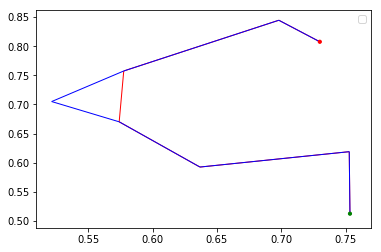

('Dijkstra path :', [81, 82, 80, 78, 74, 86, 65])
('NN path :', [81, 82, 80, 61, 78, 74, 86, 65])

The model is able to find a different path between 24 and 90


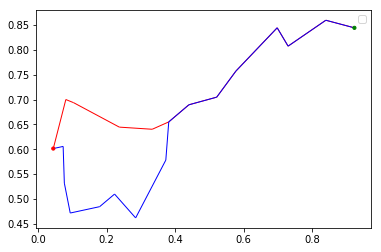

('Dijkstra path :', [24, 94, 28, 71, 30, 98, 6, 61, 80, 82, 81, 9, 90])
('NN path :', [24, 46, 36, 27, 12, 21, 91, 38, 98, 6, 61, 80, 82, 81, 9, 90])

The model is able to find a different path between 70 and 24


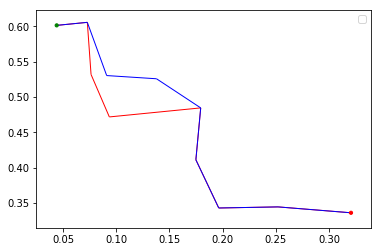

('Dijkstra path :', [70, 14, 42, 20, 12, 27, 36, 46, 24])
('NN path :', [70, 14, 42, 20, 12, 49, 66, 46, 24])



The model is able to find a different path between 59 and 82


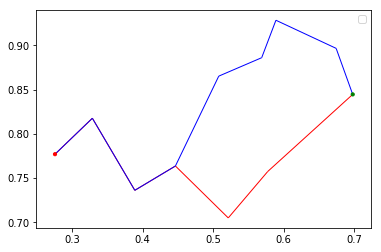

('Dijkstra path :', [59, 69, 41, 37, 61, 80, 82])
('NN path :', [59, 69, 41, 37, 13, 51, 97, 34, 82])

The model is able to find a different path between 55 and 21


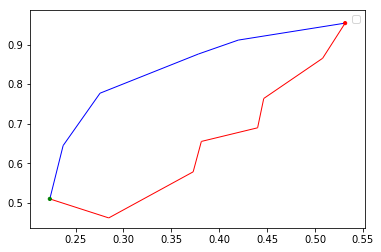

('Dijkstra path :', [55, 13, 37, 6, 98, 38, 91, 21])
('NN path :', [55, 52, 62, 59, 71, 21])

The model is able to find a different path between 38 and 52


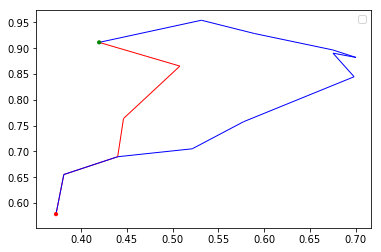

('Dijkstra path :', [38, 98, 6, 37, 13, 52])
('NN path :', [38, 98, 6, 61, 80, 82, 35, 33, 34, 97, 55, 52])



The model is able to find a different path between 25 and 11


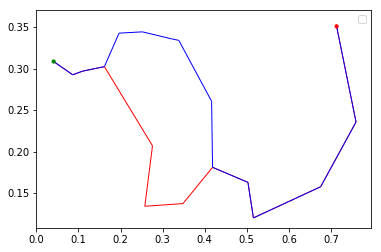

('Dijkstra path :', [25, 17, 99, 57, 64, 2, 19, 63, 87, 50, 95, 54, 11])
('NN path :', [25, 17, 99, 57, 64, 2, 84, 22, 70, 14, 42, 50, 95, 54, 11])

The model is able to find a different path between 68 and 69


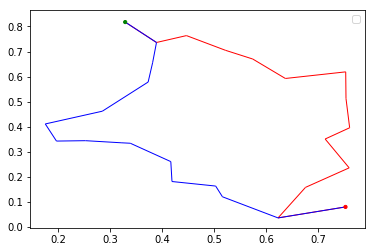

('Dijkstra path :', [68, 3, 99, 17, 25, 32, 65, 86, 74, 78, 61, 37, 41, 69])
('NN path :', [68, 3, 57, 64, 2, 84, 22, 70, 14, 42, 20, 91, 38, 98, 41, 69])

The model is able to find a different path between 7 and 38


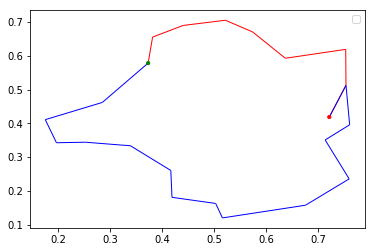

('Dijkstra path :', [7, 65, 86, 74, 78, 61, 6, 98, 38])
('NN path :', [7, 65, 32, 25, 17, 99, 57, 64, 2, 84, 22, 70, 14, 42, 20, 91, 38])



The model is able to find a different path between 65 and 28


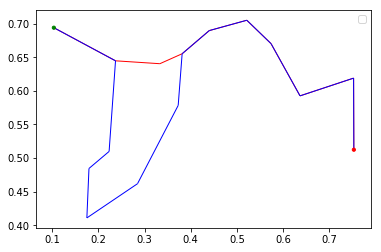

('Dijkstra path :', [65, 86, 74, 78, 61, 6, 98, 30, 71, 28])
('NN path :', [65, 86, 74, 78, 61, 6, 98, 38, 91, 20, 12, 21, 71, 28])



The model is able to find a different path between 94 and 51


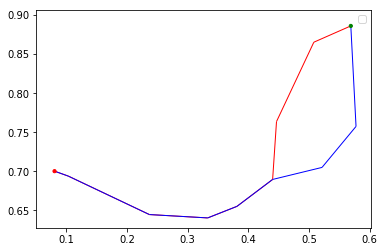

('Dijkstra path :', [94, 28, 71, 30, 98, 6, 37, 13, 51])
('NN path :', [94, 28, 71, 30, 98, 6, 61, 80, 51])

The model is able to find a different path between 69 and 68


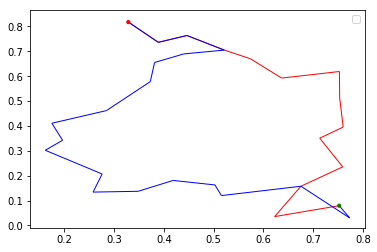

('Dijkstra path :', [69, 41, 37, 61, 78, 74, 86, 65, 32, 25, 17, 99, 3, 68])
('NN path :', [69, 41, 37, 61, 6, 98, 38, 91, 20, 42, 50, 87, 63, 19, 2, 64, 57, 99, 0, 68])



The model is able to find a different path between 78 and 87


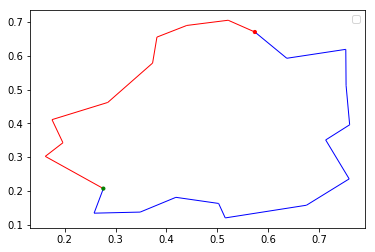

('Dijkstra path :', [78, 61, 6, 98, 38, 91, 20, 42, 50, 87])
('NN path :', [78, 74, 86, 65, 32, 25, 17, 99, 57, 64, 2, 19, 63, 87])



The model is able to find a different path between 94 and 64


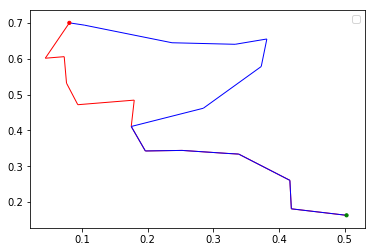

('Dijkstra path :', [94, 24, 46, 36, 27, 12, 20, 42, 14, 70, 22, 84, 2, 64])
('NN path :', [94, 28, 71, 30, 98, 38, 91, 20, 42, 14, 70, 22, 84, 2, 64])



The model is able to find a different path between 16 and 45


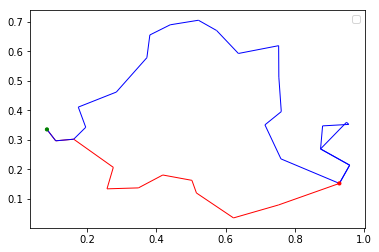

('Dijkstra path :', [16, 68, 3, 57, 64, 2, 19, 63, 87, 50, 95, 45])
('NN path :', [16, 58, 4, 1, 8, 44, 4, 58, 16, 17, 25, 32, 65, 86, 74, 78, 61, 6, 98, 38, 91, 20, 42, 50, 95, 45])

The model is able to find a different path between 42 and 37


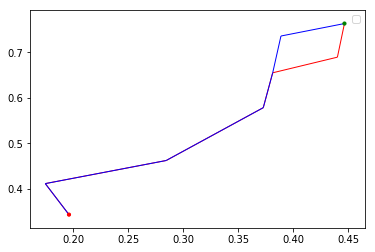

('Dijkstra path :', [42, 20, 91, 38, 98, 6, 37])
('NN path :', [42, 20, 91, 38, 98, 41, 37])



The model is able to find a different path between 36 and 25


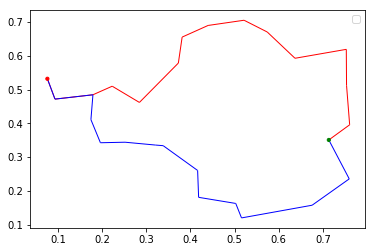

('Dijkstra path :', [36, 27, 12, 21, 91, 38, 98, 6, 61, 78, 74, 86, 65, 32, 25])
('NN path :', [36, 27, 12, 20, 42, 14, 70, 22, 84, 2, 64, 57, 99, 17, 25])

The model is able to find a different path between 29 and 15


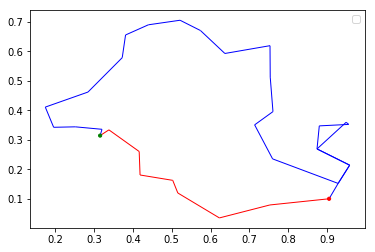

('Dijkstra path :', [29, 68, 3, 57, 64, 2, 84, 22, 15])
('NN path :', [29, 16, 58, 4, 1, 8, 44, 4, 58, 16, 17, 25, 32, 65, 86, 74, 78, 61, 6, 98, 38, 91, 20, 42, 14, 70, 15])

The model is able to find a different path between 30 and 64


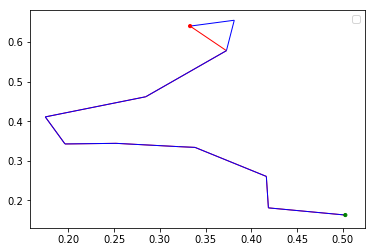

('Dijkstra path :', [30, 38, 91, 20, 42, 14, 70, 22, 84, 2, 64])
('NN path :', [30, 98, 38, 91, 20, 42, 14, 70, 22, 84, 2, 64])



The model is able to find a different path between 27 and 76


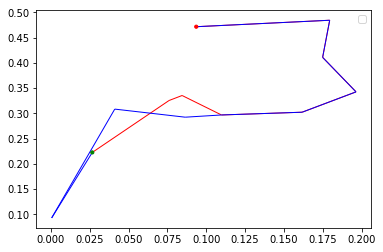

('Dijkstra path :', [27, 12, 20, 42, 50, 95, 45, 67, 76])
('NN path :', [27, 12, 20, 42, 50, 95, 54, 11, 48, 76])



The model is able to find a different path between 62 and 45


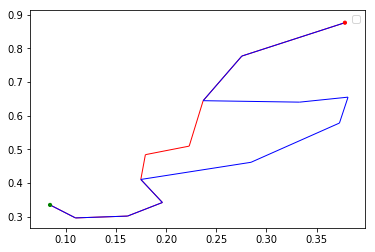

('Dijkstra path :', [62, 59, 71, 21, 12, 20, 42, 50, 95, 45])
('NN path :', [62, 59, 71, 30, 98, 38, 91, 20, 42, 50, 95, 45])

The model is able to find a different path between 37 and 76


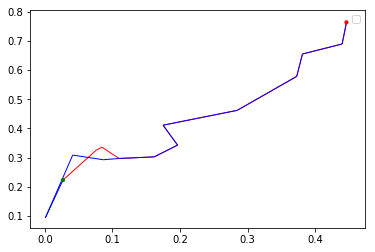

('Dijkstra path :', [37, 6, 98, 38, 91, 20, 42, 50, 95, 45, 67, 76])
('NN path :', [37, 6, 98, 38, 91, 20, 42, 50, 95, 54, 11, 48, 76])

The model is able to find a different path between 59 and 85


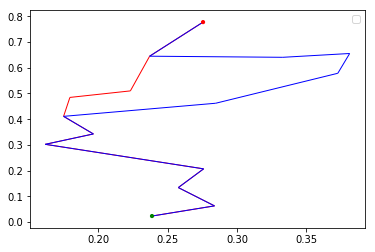

('Dijkstra path :', [59, 71, 21, 12, 20, 42, 50, 87, 63, 18, 85])
('NN path :', [59, 71, 30, 98, 38, 91, 20, 42, 50, 87, 63, 18, 85])

The model is able to find a different path between 55 and 72


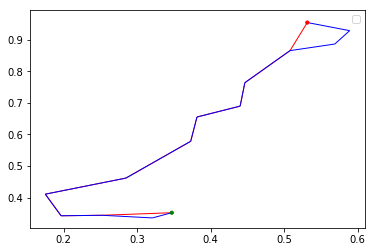

('Dijkstra path :', [55, 13, 37, 6, 98, 38, 91, 20, 42, 14, 72])
('NN path :', [55, 97, 51, 13, 37, 6, 98, 38, 91, 20, 42, 14, 70, 72])



The model is able to find a different path between 75 and 69


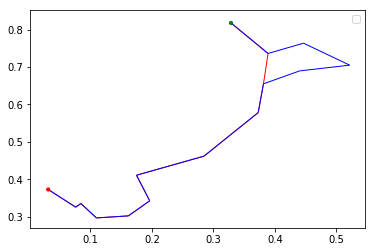

('Dijkstra path :', [75, 67, 45, 95, 50, 42, 20, 91, 38, 98, 41, 69])
('NN path :', [75, 67, 45, 95, 50, 42, 20, 91, 38, 98, 6, 61, 37, 41, 69])

The model is able to find a different path between 31 and 55


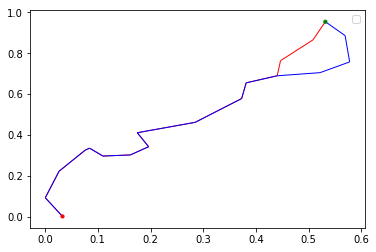

('Dijkstra path :', [31, 48, 76, 67, 45, 95, 50, 42, 20, 91, 38, 98, 6, 37, 13, 55])
('NN path :', [31, 48, 76, 67, 45, 95, 50, 42, 20, 91, 38, 98, 6, 61, 80, 51, 55])



The model is able to find a different path between 33 and 10


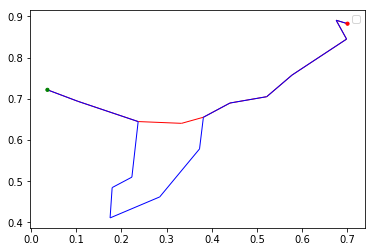

('Dijkstra path :', [33, 35, 82, 80, 61, 6, 98, 30, 71, 28, 10])
('NN path :', [33, 35, 82, 80, 61, 6, 98, 38, 91, 20, 12, 21, 71, 28, 10])



The model is able to find a different path between 88 and 97


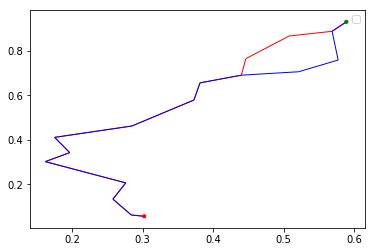

('Dijkstra path :', [88, 18, 63, 87, 50, 42, 20, 91, 38, 98, 6, 37, 13, 51, 97])
('NN path :', [88, 18, 63, 87, 50, 42, 20, 91, 38, 98, 6, 61, 80, 51, 97])

The model is able to find a different path between 3 and 7


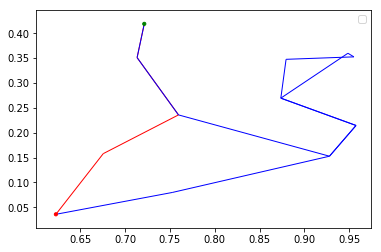

('Dijkstra path :', [3, 99, 17, 25, 7])
('NN path :', [3, 68, 16, 58, 4, 44, 8, 1, 4, 58, 16, 17, 25, 7])

The model is able to find a different path between 78 and 62


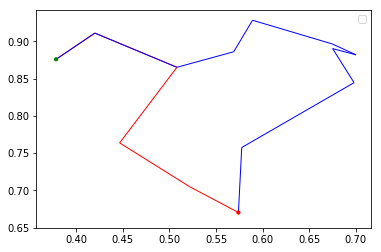

('Dijkstra path :', [78, 61, 37, 13, 52, 62])
('NN path :', [78, 80, 82, 35, 33, 34, 97, 51, 13, 52, 62])

The model is able to find a different path between 43 and 2


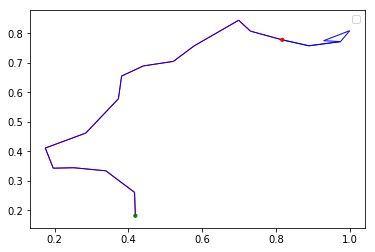

('Dijkstra path :', [43, 81, 82, 80, 61, 6, 98, 38, 91, 20, 42, 14, 70, 22, 84, 2])
('NN path :', [43, 60, 83, 73, 26, 83, 60, 43, 81, 82, 80, 61, 6, 98, 38, 91, 20, 42, 14, 70, 22, 84, 2])

The model is able to find a different path between 66 and 26


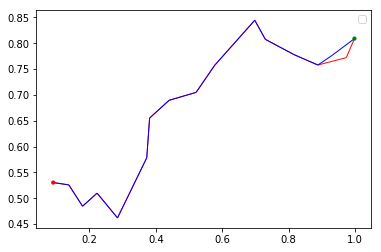

('Dijkstra path :', [66, 49, 12, 21, 91, 38, 98, 6, 61, 80, 82, 81, 43, 60, 83, 26])
('NN path :', [66, 49, 12, 21, 91, 38, 98, 6, 61, 80, 82, 81, 43, 60, 73, 26])



The model is able to find a different path between 27 and 41


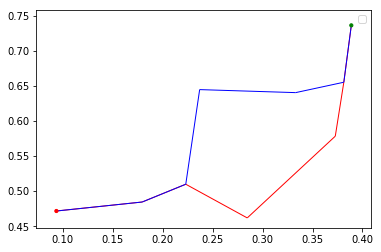

('Dijkstra path :', [27, 12, 21, 91, 38, 98, 41])
('NN path :', [27, 12, 21, 71, 30, 98, 41])



The model is able to find a different path between 28 and 58


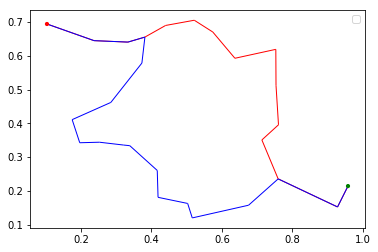

('Dijkstra path :', [28, 71, 30, 98, 6, 61, 78, 74, 86, 65, 32, 25, 17, 16, 58])
('NN path :', [28, 71, 30, 98, 38, 91, 20, 42, 14, 70, 22, 84, 2, 64, 57, 99, 17, 16, 58])

The model is able to find a different path between 40 and 28


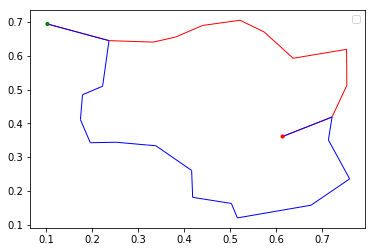

('Dijkstra path :', [40, 7, 65, 86, 74, 78, 61, 6, 98, 30, 71, 28])
('NN path :', [40, 7, 25, 17, 99, 57, 64, 2, 84, 22, 70, 14, 42, 20, 12, 21, 71, 28])

The model is able to find a different path between 33 and 42


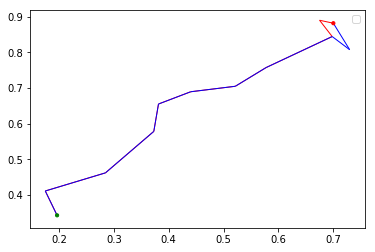

('Dijkstra path :', [33, 35, 82, 80, 61, 6, 98, 38, 91, 20, 42])
('NN path :', [33, 81, 82, 80, 61, 6, 98, 38, 91, 20, 42])

The model is able to find a different path between 17 and 85


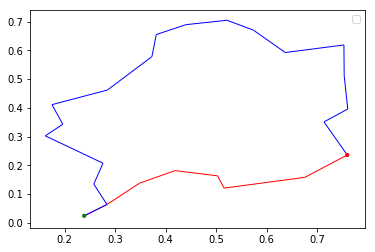

('Dijkstra path :', [17, 99, 57, 64, 2, 19, 18, 85])
('NN path :', [17, 25, 32, 65, 86, 74, 78, 61, 6, 98, 38, 91, 20, 42, 50, 87, 63, 18, 85])



The model is able to find a different path between 36 and 94


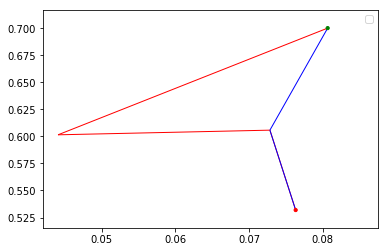

('Dijkstra path :', [36, 46, 24, 94])
('NN path :', [36, 46, 94])

The model is able to find a different path between 25 and 36


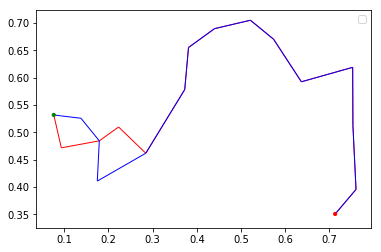

('Dijkstra path :', [25, 32, 65, 86, 74, 78, 61, 6, 98, 38, 91, 21, 12, 27, 36])
('NN path :', [25, 32, 65, 86, 74, 78, 61, 6, 98, 38, 91, 20, 12, 49, 66, 36])



The model is able to find a different path between 11 and 70


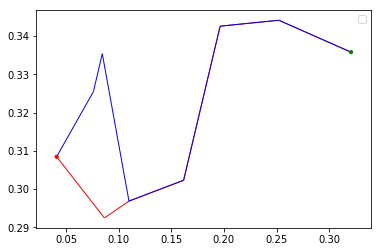

('Dijkstra path :', [11, 54, 95, 50, 42, 14, 70])
('NN path :', [11, 67, 45, 95, 50, 42, 14, 70])

The model is able to find a different path between 62 and 25


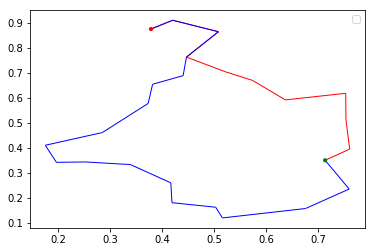

('Dijkstra path :', [62, 52, 13, 37, 61, 78, 74, 86, 65, 32, 25])
('NN path :', [62, 52, 13, 37, 6, 98, 38, 91, 20, 42, 14, 70, 22, 84, 2, 64, 57, 99, 17, 25])

The model is able to find a different path between 77 and 62


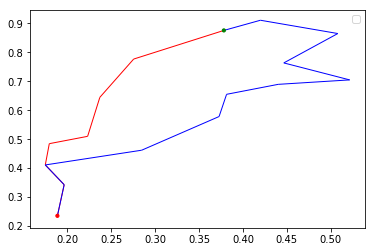

('Dijkstra path :', [77, 42, 20, 12, 21, 71, 59, 62])
('NN path :', [77, 42, 20, 91, 38, 98, 6, 61, 37, 13, 52, 62])

The model is able to find a different path between 16 and 27


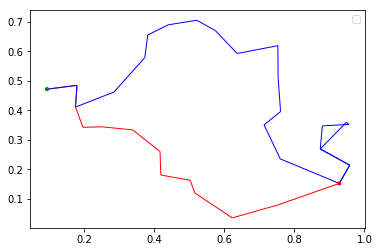

('Dijkstra path :', [16, 68, 3, 57, 64, 2, 84, 22, 70, 14, 42, 20, 12, 27])
('NN path :', [16, 58, 4, 1, 8, 44, 4, 58, 16, 17, 25, 32, 65, 86, 74, 78, 61, 6, 98, 38, 91, 20, 12, 27])



The model is able to find a different path between 45 and 51


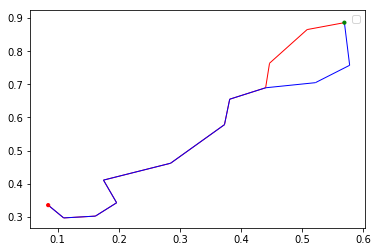

('Dijkstra path :', [45, 95, 50, 42, 20, 91, 38, 98, 6, 37, 13, 51])
('NN path :', [45, 95, 50, 42, 20, 91, 38, 98, 6, 61, 80, 51])



The model is able to find a different path between 81 and 31


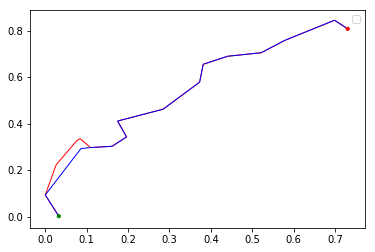

('Dijkstra path :', [81, 82, 80, 61, 6, 98, 38, 91, 20, 42, 50, 95, 45, 67, 76, 48, 31])
('NN path :', [81, 82, 80, 61, 6, 98, 38, 91, 20, 42, 50, 95, 54, 48, 31])



The model is able to find a different path between 26 and 32


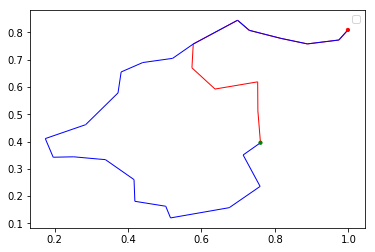

('Dijkstra path :', [26, 83, 60, 43, 81, 82, 80, 78, 74, 86, 65, 32])
('NN path :', [26, 83, 60, 43, 81, 82, 80, 61, 6, 98, 38, 91, 20, 42, 14, 70, 22, 84, 2, 64, 57, 99, 17, 25, 32])



The model is able to find a different path between 17 and 36


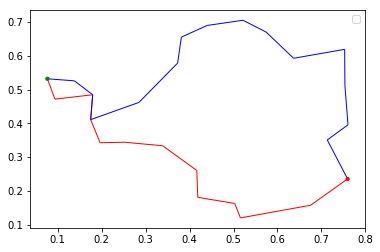

('Dijkstra path :', [17, 99, 57, 64, 2, 84, 22, 70, 14, 42, 20, 12, 27, 36])
('NN path :', [17, 25, 32, 65, 86, 74, 78, 61, 6, 98, 38, 91, 20, 12, 49, 66, 36])



The model is able to find a different path between 41 and 27


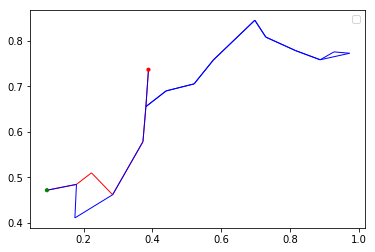

('Dijkstra path :', [41, 98, 38, 91, 21, 12, 27])
('NN path :', [41, 98, 6, 61, 80, 82, 81, 43, 60, 83, 73, 60, 43, 81, 82, 80, 61, 6, 98, 38, 91, 20, 12, 27])

The model is able to find a different path between 88 and 51


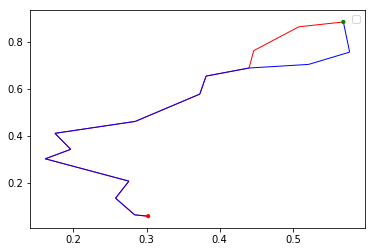

('Dijkstra path :', [88, 18, 63, 87, 50, 42, 20, 91, 38, 98, 6, 37, 13, 51])
('NN path :', [88, 18, 63, 87, 50, 42, 20, 91, 38, 98, 6, 61, 80, 51])

The model is able to find a different path between 1 and 62


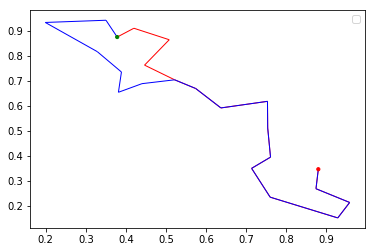

('Dijkstra path :', [1, 4, 58, 16, 17, 25, 32, 65, 86, 74, 78, 61, 37, 13, 52, 62])
('NN path :', [1, 4, 58, 16, 17, 25, 32, 65, 86, 74, 78, 61, 6, 98, 41, 69, 79, 93, 62])

The model is able to find a different path between 91 and 84


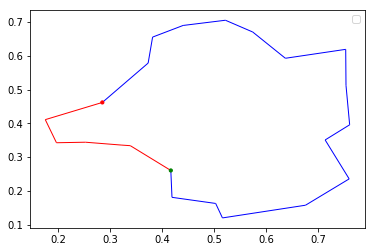

('Dijkstra path :', [91, 20, 42, 14, 70, 22, 84])
('NN path :', [91, 38, 98, 6, 61, 78, 74, 86, 65, 32, 25, 17, 99, 57, 64, 2, 84])

The model is able to find a different path between 34 and 17


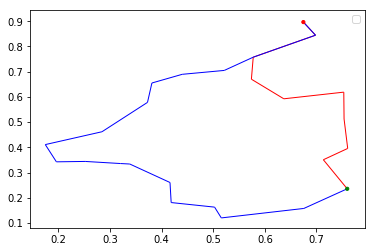

('Dijkstra path :', [34, 82, 80, 78, 74, 86, 65, 32, 25, 17])
('NN path :', [34, 82, 80, 61, 6, 98, 38, 91, 20, 42, 14, 70, 22, 84, 2, 64, 57, 99, 17])

The model is able to find a different path between 60 and 64


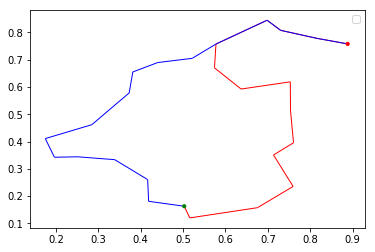

('Dijkstra path :', [60, 43, 81, 82, 80, 78, 74, 86, 65, 32, 25, 17, 99, 57, 64])
('NN path :', [60, 43, 81, 82, 80, 61, 6, 98, 38, 91, 20, 42, 14, 70, 22, 84, 2, 64])



The model is able to find a different path between 28 and 40


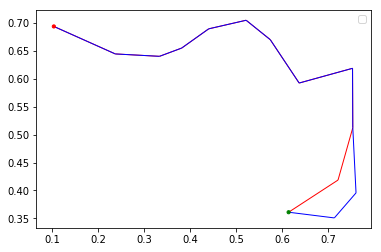

('Dijkstra path :', [28, 71, 30, 98, 6, 61, 78, 74, 86, 65, 7, 40])
('NN path :', [28, 71, 30, 98, 6, 61, 78, 74, 86, 65, 32, 25, 40])



The model is able to find a different path between 51 and 94


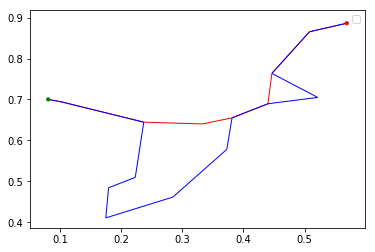

('Dijkstra path :', [51, 13, 37, 6, 98, 30, 71, 28, 94])
('NN path :', [51, 13, 37, 61, 6, 98, 38, 91, 20, 12, 21, 71, 28, 94])

The model is able to find a different path between 55 and 31


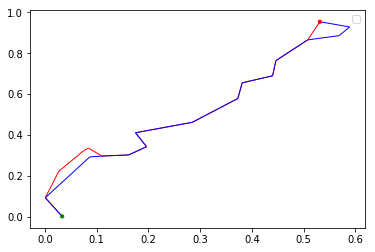

('Dijkstra path :', [55, 13, 37, 6, 98, 38, 91, 20, 42, 50, 95, 45, 67, 76, 48, 31])
('NN path :', [55, 97, 51, 13, 37, 6, 98, 38, 91, 20, 42, 50, 95, 54, 48, 31])



The model is able to find a different path between 21 and 39


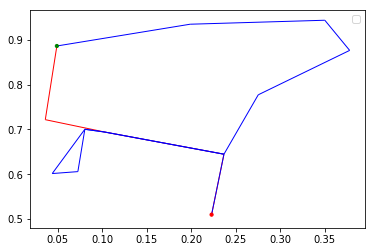

('Dijkstra path :', [21, 71, 28, 10, 39])
('NN path :', [21, 71, 28, 94, 24, 46, 94, 28, 71, 59, 62, 93, 79, 39])

The model is able to find a different path between 41 and 9


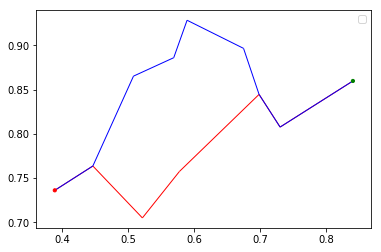

('Dijkstra path :', [41, 37, 61, 80, 82, 81, 9])
('NN path :', [41, 37, 13, 51, 97, 34, 82, 81, 9])

The model is able to find a different path between 17 and 34


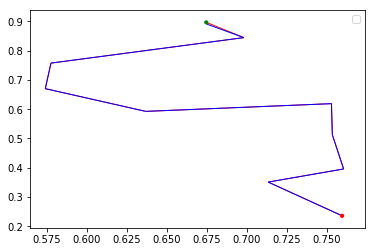

('Dijkstra path :', [17, 25, 32, 65, 86, 74, 78, 80, 82, 34])
('NN path :', [17, 25, 32, 65, 86, 74, 78, 80, 82, 35, 34])

The model is able to find a different path between 30 and 20


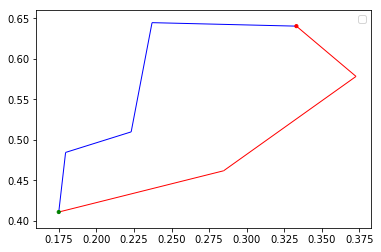

('Dijkstra path :', [30, 38, 91, 20])
('NN path :', [30, 71, 21, 12, 20])

The model is able to find a different path between 76 and 37


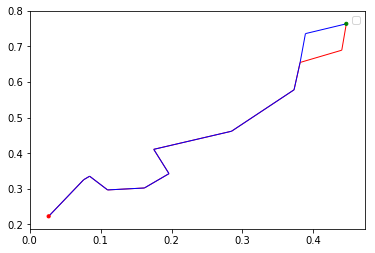

('Dijkstra path :', [76, 67, 45, 95, 50, 42, 20, 91, 38, 98, 6, 37])
('NN path :', [76, 67, 45, 95, 50, 42, 20, 91, 38, 98, 41, 37])



The model is able to find a different path between 63 and 10


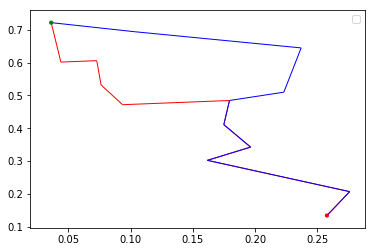

('Dijkstra path :', [63, 87, 50, 42, 20, 12, 27, 36, 46, 24, 10])
('NN path :', [63, 87, 50, 42, 20, 12, 21, 71, 28, 10])

The model is able to find a different path between 97 and 88


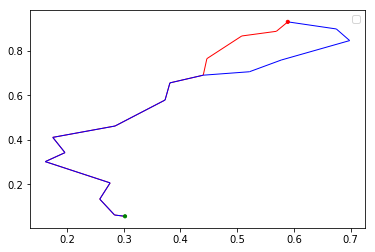

('Dijkstra path :', [97, 51, 13, 37, 6, 98, 38, 91, 20, 42, 50, 87, 63, 18, 88])
('NN path :', [97, 34, 82, 80, 61, 6, 98, 38, 91, 20, 42, 50, 87, 63, 18, 88])



The model is able to find a different path between 59 and 7


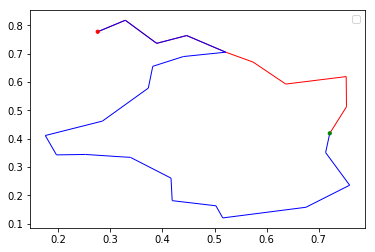

('Dijkstra path :', [59, 69, 41, 37, 61, 78, 74, 86, 65, 7])
('NN path :', [59, 69, 41, 37, 61, 6, 98, 38, 91, 20, 42, 14, 70, 22, 84, 2, 64, 57, 99, 17, 25, 7])

The model is able to find a different path between 93 and 41


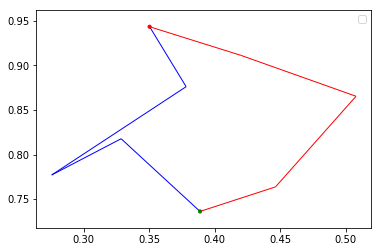

('Dijkstra path :', [93, 52, 13, 37, 41])
('NN path :', [93, 62, 59, 69, 41])



The model is able to find a different path between 55 and 27


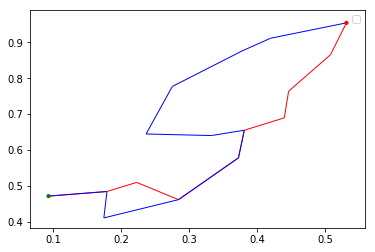

('Dijkstra path :', [55, 13, 37, 6, 98, 38, 91, 21, 12, 27])
('NN path :', [55, 52, 62, 59, 71, 30, 98, 38, 91, 20, 12, 27])

The model is able to find a different path between 90 and 58


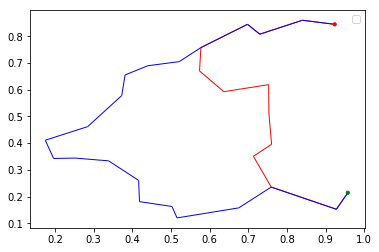

('Dijkstra path :', [90, 9, 81, 82, 80, 78, 74, 86, 65, 32, 25, 17, 16, 58])
('NN path :', [90, 9, 81, 82, 80, 61, 6, 98, 38, 91, 20, 42, 14, 70, 22, 84, 2, 64, 57, 99, 17, 16, 58])



The model is able to find a different path between 26 and 66


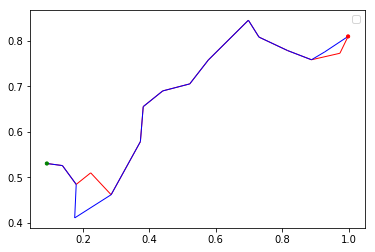

('Dijkstra path :', [26, 83, 60, 43, 81, 82, 80, 61, 6, 98, 38, 91, 21, 12, 49, 66])
('NN path :', [26, 73, 60, 43, 81, 82, 80, 61, 6, 98, 38, 91, 20, 12, 49, 66])



The model is able to find a different path between 28 and 54


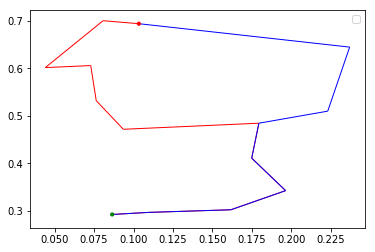

('Dijkstra path :', [28, 94, 24, 46, 36, 27, 12, 20, 42, 50, 95, 54])
('NN path :', [28, 71, 21, 12, 20, 42, 50, 95, 54])

The model is able to find a different path between 9 and 41


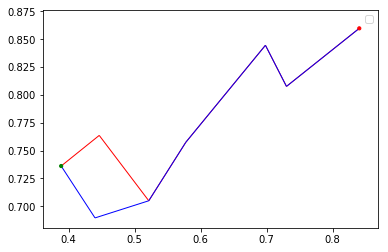

('Dijkstra path :', [9, 81, 82, 80, 61, 37, 41])
('NN path :', [9, 81, 82, 80, 61, 6, 41])

The model is able to find a different path between 12 and 96


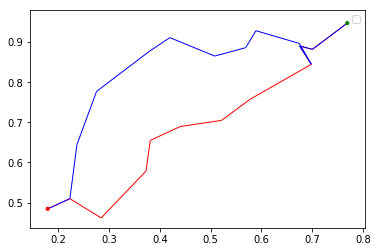

('Dijkstra path :', [12, 21, 91, 38, 98, 6, 61, 80, 82, 35, 33, 96])
('NN path :', [12, 21, 71, 59, 62, 52, 13, 51, 97, 34, 82, 35, 33, 96])



The model is able to find a different path between 32 and 26


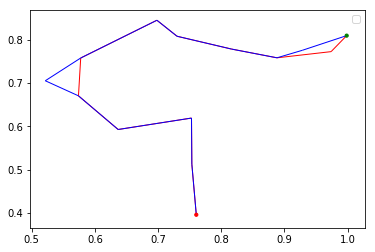

('Dijkstra path :', [32, 65, 86, 74, 78, 80, 82, 81, 43, 60, 83, 26])
('NN path :', [32, 65, 86, 74, 78, 61, 80, 82, 81, 43, 60, 73, 26])

The model is able to find a different path between 95 and 49


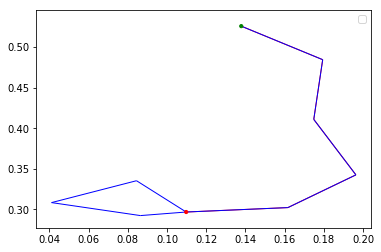

('Dijkstra path :', [95, 50, 42, 20, 12, 49])
('NN path :', [95, 54, 11, 45, 95, 50, 42, 20, 12, 49])



The model is able to find a different path between 44 and 12


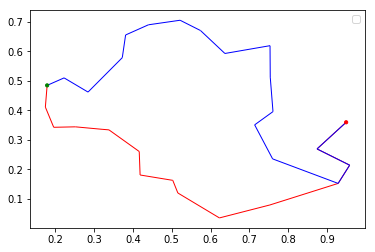

('Dijkstra path :', [44, 4, 58, 16, 68, 3, 57, 64, 2, 84, 22, 70, 14, 42, 20, 12])
('NN path :', [44, 4, 58, 16, 17, 25, 32, 65, 86, 74, 78, 61, 6, 98, 38, 91, 21, 12])



The model is able to find a different path between 7 and 52


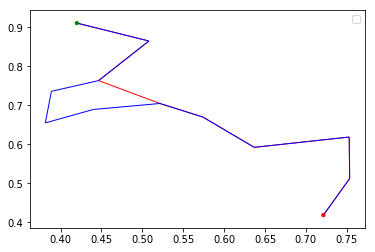

('Dijkstra path :', [7, 65, 86, 74, 78, 61, 37, 13, 52])
('NN path :', [7, 65, 86, 74, 78, 61, 6, 98, 41, 37, 13, 52])



The model is able to find a different path between 36 and 7


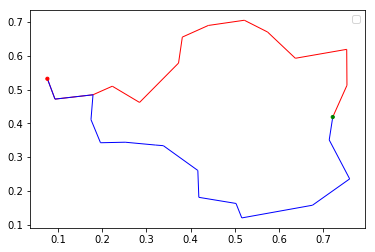

('Dijkstra path :', [36, 27, 12, 21, 91, 38, 98, 6, 61, 78, 74, 86, 65, 7])
('NN path :', [36, 27, 12, 20, 42, 14, 70, 22, 84, 2, 64, 57, 99, 17, 25, 7])

The model is able to find a different path between 3 and 21


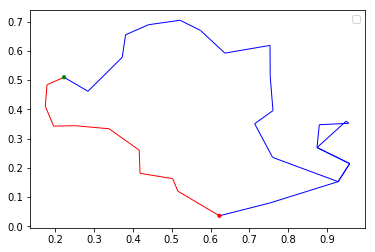

('Dijkstra path :', [3, 57, 64, 2, 84, 22, 70, 14, 42, 20, 12, 21])
('NN path :', [3, 68, 16, 58, 4, 1, 8, 44, 4, 58, 16, 17, 25, 32, 65, 86, 74, 78, 61, 6, 98, 38, 91, 21])

The model is able to find a different path between 65 and 81

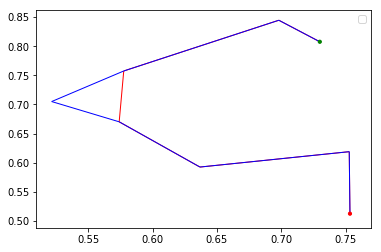

('Dijkstra path :', [65, 86, 74, 78, 80, 82, 81])
('NN path :', [65, 86, 74, 78, 61, 80, 82, 81])

The model is able to find a different path between 9 and 76


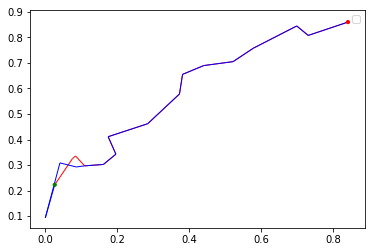

('Dijkstra path :', [9, 81, 82, 80, 61, 6, 98, 38, 91, 20, 42, 50, 95, 45, 67, 76])
('NN path :', [9, 81, 82, 80, 61, 6, 98, 38, 91, 20, 42, 50, 95, 54, 11, 48, 76])



The model is able to find a different path between 68 and 40


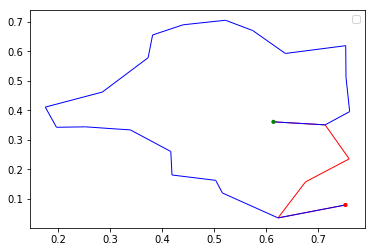

('Dijkstra path :', [68, 3, 99, 17, 25, 40])
('NN path :', [68, 3, 57, 64, 2, 84, 22, 70, 14, 42, 20, 91, 38, 98, 6, 61, 78, 74, 86, 65, 32, 25, 40])



The model is able to find a different path between 64 and 94


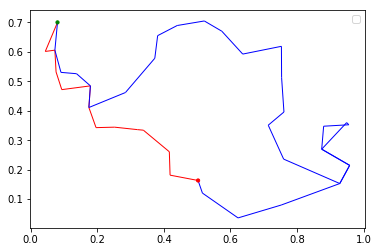

('Dijkstra path :', [64, 2, 84, 22, 70, 14, 42, 20, 12, 27, 36, 46, 24, 94])
('NN path :', [64, 57, 3, 68, 16, 58, 4, 1, 8, 44, 4, 58, 16, 17, 25, 32, 65, 86, 74, 78, 61, 6, 98, 38, 91, 20, 12, 49, 66, 46, 94])

The model is able to find a different path between 52 and 7


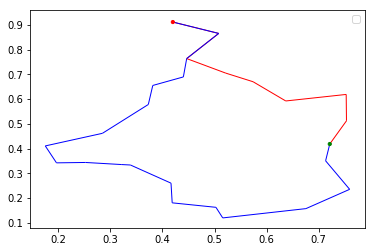

('Dijkstra path :', [52, 13, 37, 61, 78, 74, 86, 65, 7])
('NN path :', [52, 13, 37, 6, 98, 38, 91, 20, 42, 14, 70, 22, 84, 2, 64, 57, 99, 17, 25, 7])

The model is able to find a different path between 43 and 24


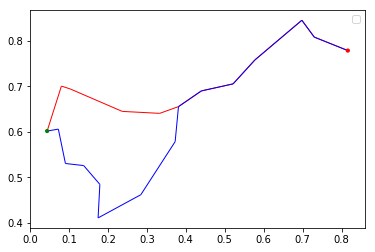

('Dijkstra path :', [43, 81, 82, 80, 61, 6, 98, 30, 71, 28, 94, 24])
('NN path :', [43, 81, 82, 80, 61, 6, 98, 38, 91, 20, 12, 49, 66, 46, 24])

The model is able to find a different path between 32 and 28


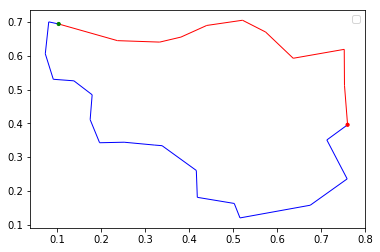

('Dijkstra path :', [32, 65, 86, 74, 78, 61, 6, 98, 30, 71, 28])
('NN path :', [32, 25, 17, 99, 57, 64, 2, 84, 22, 70, 14, 42, 20, 12, 49, 66, 46, 94, 28])

The model is able to find a different path between 6 and 76


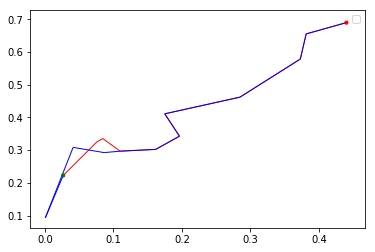

('Dijkstra path :', [6, 98, 38, 91, 20, 42, 50, 95, 45, 67, 76])
('NN path :', [6, 98, 38, 91, 20, 42, 50, 95, 54, 11, 48, 76])

The model is able to find a different path between 27 and 55


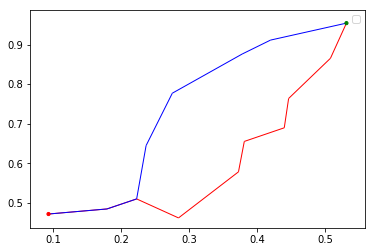

('Dijkstra path :', [27, 12, 21, 91, 38, 98, 6, 37, 13, 55])
('NN path :', [27, 12, 21, 71, 59, 62, 52, 55])



The model is able to find a different path between 23 and 24


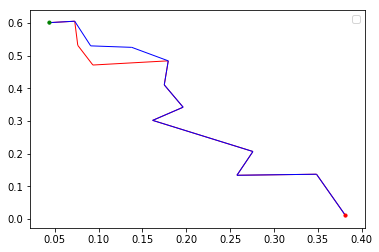

('Dijkstra path :', [23, 19, 63, 87, 50, 42, 20, 12, 27, 36, 46, 24])
('NN path :', [23, 19, 63, 87, 50, 42, 20, 12, 49, 66, 46, 24])

The model is able to find a different path between 98 and 68


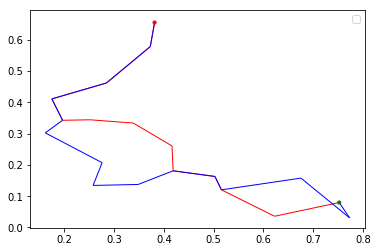

('Dijkstra path :', [98, 38, 91, 20, 42, 14, 70, 22, 84, 2, 64, 57, 3, 68])
('NN path :', [98, 38, 91, 20, 42, 50, 87, 63, 19, 2, 64, 57, 99, 0, 68])

The model is able to find a different path between 73 and 12


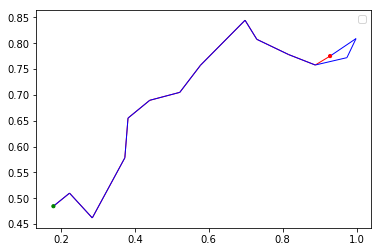

('Dijkstra path :', [73, 60, 43, 81, 82, 80, 61, 6, 98, 38, 91, 21, 12])
('NN path :', [73, 26, 83, 60, 43, 81, 82, 80, 61, 6, 98, 38, 91, 21, 12])



The model is able to find a different path between 69 and 81


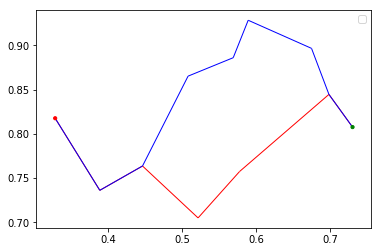

('Dijkstra path :', [69, 41, 37, 61, 80, 82, 81])
('NN path :', [69, 41, 37, 13, 51, 97, 34, 82, 81])

The model is able to find a different path between 12 and 34


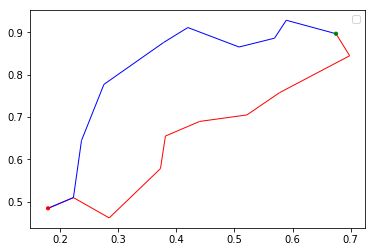

('Dijkstra path :', [12, 21, 91, 38, 98, 6, 61, 80, 82, 34])
('NN path :', [12, 21, 71, 59, 62, 52, 13, 51, 97, 34])

The model is able to find a different path between 80 and 71


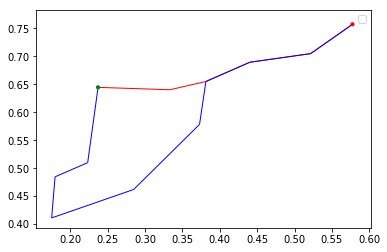

('Dijkstra path :', [80, 61, 6, 98, 30, 71])
('NN path :', [80, 61, 6, 98, 38, 91, 20, 12, 21, 71])



The model is able to find a different path between 80 and 99


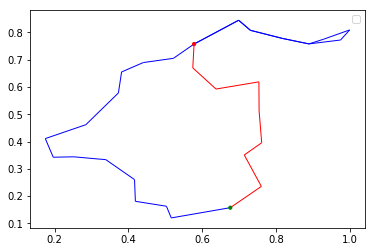

('Dijkstra path :', [80, 78, 74, 86, 65, 32, 25, 17, 99])
('NN path :', [80, 82, 81, 43, 60, 83, 26, 73, 60, 43, 81, 82, 80, 61, 6, 98, 38, 91, 20, 42, 14, 70, 22, 84, 2, 64, 57, 99])



The model is able to find a different path between 14 and 98


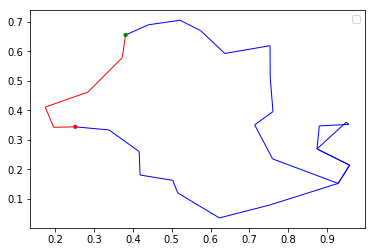

('Dijkstra path :', [14, 42, 20, 91, 38, 98])
('NN path :', [14, 70, 22, 84, 2, 64, 57, 3, 68, 16, 58, 4, 1, 8, 44, 4, 58, 16, 17, 25, 32, 65, 86, 74, 78, 61, 6, 98])



The model is able to find a different path between 86 and 76


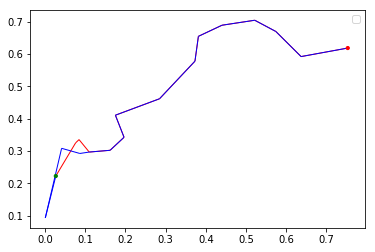

('Dijkstra path :', [86, 74, 78, 61, 6, 98, 38, 91, 20, 42, 50, 95, 45, 67, 76])
('NN path :', [86, 74, 78, 61, 6, 98, 38, 91, 20, 42, 50, 95, 54, 11, 48, 76])



The model is able to find a different path between 14 and 24


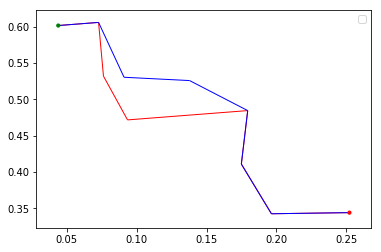

('Dijkstra path :', [14, 42, 20, 12, 27, 36, 46, 24])
('NN path :', [14, 42, 20, 12, 49, 66, 46, 24])



The model is able to find a different path between 81 and 69


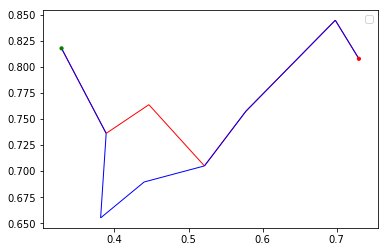

('Dijkstra path :', [81, 82, 80, 61, 37, 41, 69])
('NN path :', [81, 82, 80, 61, 6, 98, 41, 69])



The model is able to find a different path between 40 and 68


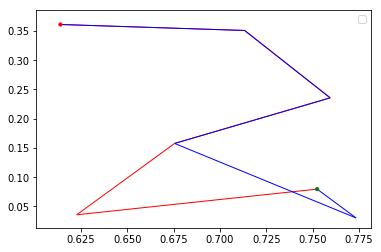

('Dijkstra path :', [40, 25, 17, 99, 3, 68])
('NN path :', [40, 25, 17, 99, 0, 68])

The model is able to find a different path between 9 and 16


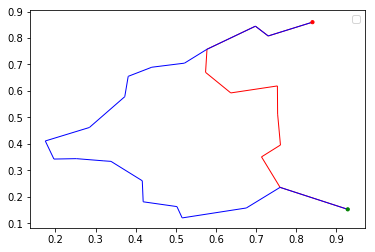

('Dijkstra path :', [9, 81, 82, 80, 78, 74, 86, 65, 32, 25, 17, 16])
('NN path :', [9, 81, 82, 80, 61, 6, 98, 38, 91, 20, 42, 14, 70, 22, 84, 2, 64, 57, 99, 17, 16])



The model is able to find a different path between 90 and 24


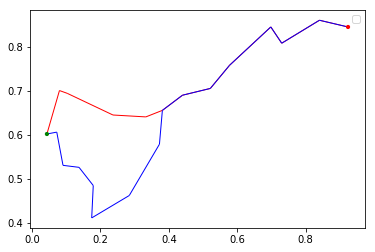

('Dijkstra path :', [90, 9, 81, 82, 80, 61, 6, 98, 30, 71, 28, 94, 24])
('NN path :', [90, 9, 81, 82, 80, 61, 6, 98, 38, 91, 20, 12, 49, 66, 46, 24])

The model is able to find a different path between 17 and 73


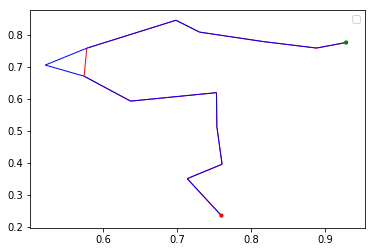

('Dijkstra path :', [17, 25, 32, 65, 86, 74, 78, 80, 82, 81, 43, 60, 73])
('NN path :', [17, 25, 32, 65, 86, 74, 78, 61, 80, 82, 81, 43, 60, 73])

The model is able to find a different path between 62 and 77


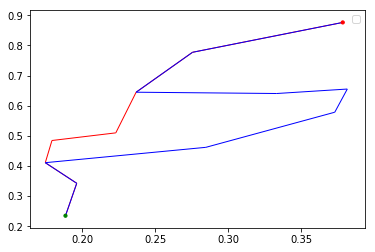

('Dijkstra path :', [62, 59, 71, 21, 12, 20, 42, 77])
('NN path :', [62, 59, 71, 30, 98, 38, 91, 20, 42, 77])

The model is able to find a different path between 21 and 46


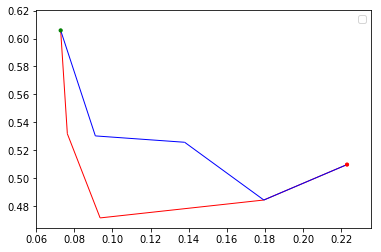

('Dijkstra path :', [21, 12, 27, 36, 46])
('NN path :', [21, 12, 49, 66, 46])



The model is able to find a different path between 29 and 24


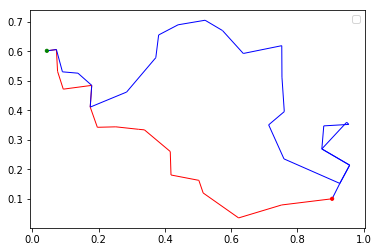

('Dijkstra path :', [29, 68, 3, 57, 64, 2, 84, 22, 70, 14, 42, 20, 12, 27, 36, 46, 24])
('NN path :', [29, 16, 58, 4, 1, 8, 44, 4, 58, 16, 17, 25, 32, 65, 86, 74, 78, 61, 6, 98, 38, 91, 20, 12, 49, 66, 46, 24])



The model is able to find a different path between 41 and 93


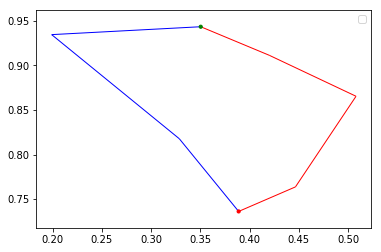

('Dijkstra path :', [41, 37, 13, 52, 93])
('NN path :', [41, 69, 79, 93])



The model is able to find a different path between 55 and 25


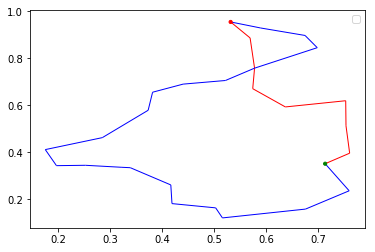

('Dijkstra path :', [55, 51, 80, 78, 74, 86, 65, 32, 25])
('NN path :', [55, 97, 34, 82, 80, 61, 6, 98, 38, 91, 20, 42, 14, 70, 22, 84, 2, 64, 57, 99, 17, 25])



The model is able to find a different path between 11 and 25


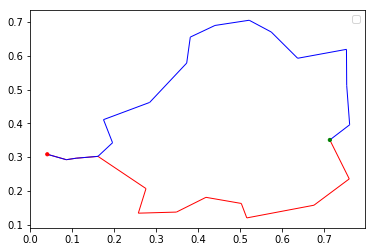

('Dijkstra path :', [11, 54, 95, 50, 87, 63, 19, 2, 64, 57, 99, 17, 25])
('NN path :', [11, 54, 95, 50, 42, 20, 91, 38, 98, 6, 61, 78, 74, 86, 65, 32, 25])



The model is able to find a different path between 28 and 32


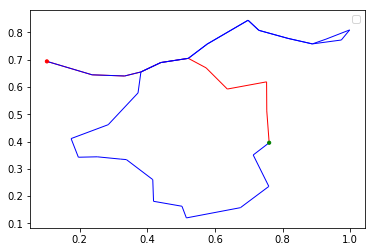

('Dijkstra path :', [28, 71, 30, 98, 6, 61, 78, 74, 86, 65, 32])
('NN path :', [28, 71, 30, 98, 6, 61, 80, 82, 81, 43, 60, 83, 26, 73, 60, 43, 81, 82, 80, 61, 6, 98, 38, 91, 20, 42, 14, 70, 22, 84, 2, 64, 57, 99, 17, 25, 32])

The model is able to find a different path between 73 and 99


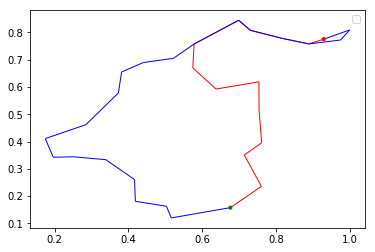

('Dijkstra path :', [73, 60, 43, 81, 82, 80, 78, 74, 86, 65, 32, 25, 17, 99])
('NN path :', [73, 26, 83, 60, 43, 81, 82, 80, 61, 6, 98, 38, 91, 20, 42, 14, 70, 22, 84, 2, 64, 57, 99])

The model is able to find a different path between 25 and 62


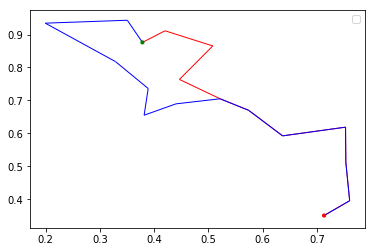

('Dijkstra path :', [25, 32, 65, 86, 74, 78, 61, 37, 13, 52, 62])
('NN path :', [25, 32, 65, 86, 74, 78, 61, 6, 98, 41, 69, 79, 93, 62])



The model is able to find a different path between 23 and 15


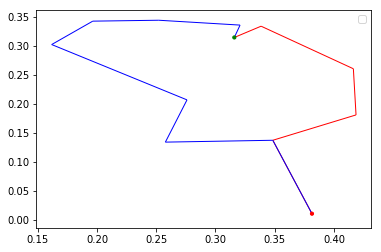

('Dijkstra path :', [23, 19, 2, 84, 22, 15])
('NN path :', [23, 19, 63, 87, 50, 42, 14, 70, 15])



The model is able to find a different path between 19 and 98


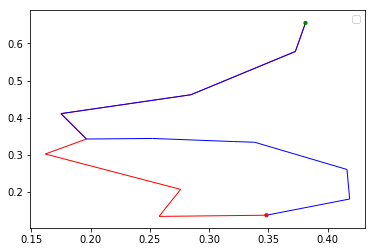

('Dijkstra path :', [19, 63, 87, 50, 42, 20, 91, 38, 98])
('NN path :', [19, 2, 84, 22, 70, 14, 42, 20, 91, 38, 98])

The model is able to find a different path between 72 and 84


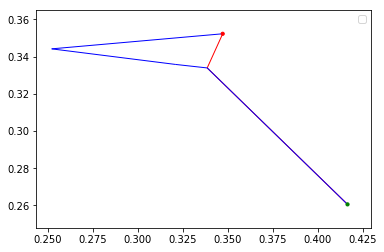

('Dijkstra path :', [72, 22, 84])
('NN path :', [72, 14, 70, 22, 84])



The model is able to find a different path between 58 and 28


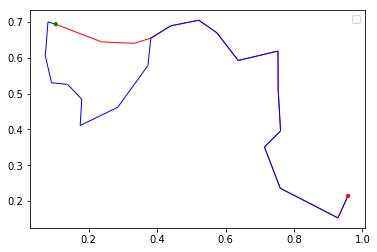

('Dijkstra path :', [58, 16, 17, 25, 32, 65, 86, 74, 78, 61, 6, 98, 30, 71, 28])
('NN path :', [58, 16, 17, 25, 32, 65, 86, 74, 78, 61, 6, 98, 38, 91, 20, 12, 49, 66, 46, 94, 28])



The model is able to find a different path between 54 and 28


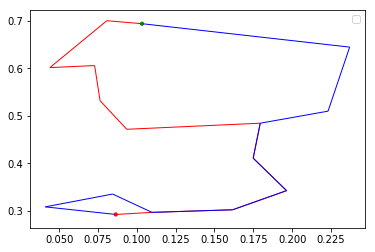

('Dijkstra path :', [54, 95, 50, 42, 20, 12, 27, 36, 46, 24, 94, 28])
('NN path :', [54, 11, 45, 95, 50, 42, 20, 12, 21, 71, 28])

The model is able to find a different path between 45 and 16


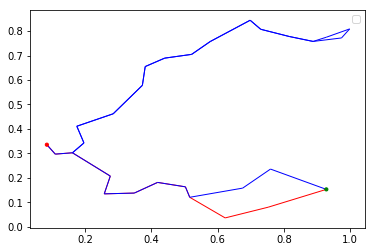

('Dijkstra path :', [45, 95, 50, 87, 63, 19, 2, 64, 57, 3, 68, 16])
('NN path :', [45, 95, 50, 42, 20, 91, 38, 98, 6, 61, 80, 82, 81, 43, 60, 83, 26, 73, 60, 43, 81, 82, 80, 61, 6, 98, 38, 91, 20, 42, 50, 87, 63, 19, 2, 64, 57, 99, 17, 16])

The model is able to find a different path between 71 and 52


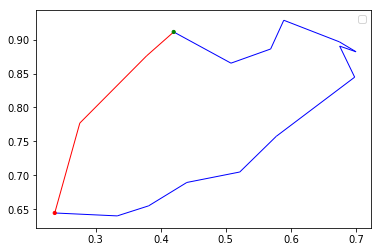

('Dijkstra path :', [71, 59, 62, 52])
('NN path :', [71, 30, 98, 6, 61, 80, 82, 35, 33, 34, 97, 51, 13, 52])



The model is able to find a different path between 98 and 24


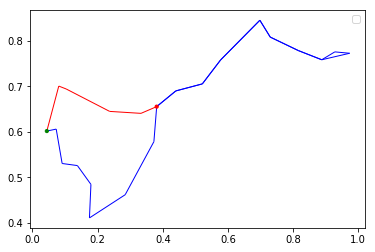

('Dijkstra path :', [98, 30, 71, 28, 94, 24])
('NN path :', [98, 6, 61, 80, 82, 81, 43, 60, 83, 73, 60, 43, 81, 82, 80, 61, 6, 98, 38, 91, 20, 12, 49, 66, 46, 24])

The model is able to find a different path between 72 and 25


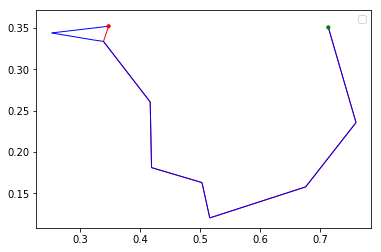

('Dijkstra path :', [72, 22, 84, 2, 64, 57, 99, 17, 25])
('NN path :', [72, 14, 70, 22, 84, 2, 64, 57, 99, 17, 25])



The model is able to find a different path between 24 and 43


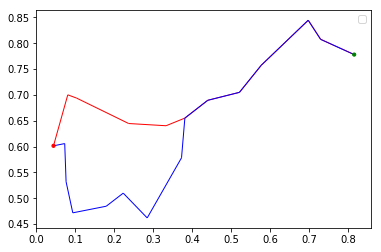

('Dijkstra path :', [24, 94, 28, 71, 30, 98, 6, 61, 80, 82, 81, 43])
('NN path :', [24, 46, 36, 27, 12, 21, 91, 38, 98, 6, 61, 80, 82, 81, 43])

The model is able to find a different path between 80 and 41


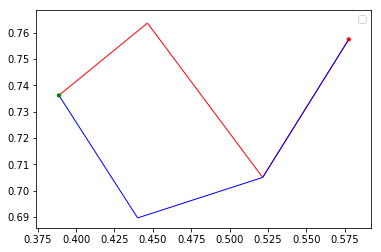

('Dijkstra path :', [80, 61, 37, 41])
('NN path :', [80, 61, 6, 41])

The model is able to find a different path between 11 and 62


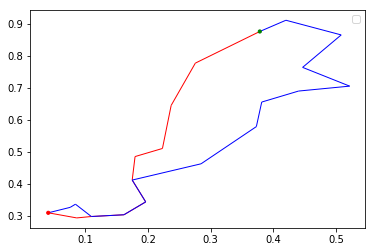

('Dijkstra path :', [11, 54, 95, 50, 42, 20, 12, 21, 71, 59, 62])
('NN path :', [11, 67, 45, 95, 50, 42, 20, 91, 38, 98, 6, 61, 37, 13, 52, 62])

The model is able to find a different path between 51 and 0


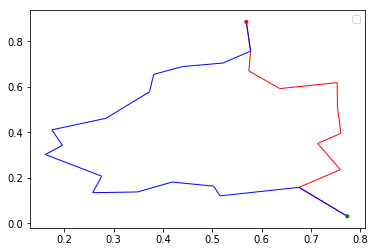

('Dijkstra path :', [51, 80, 78, 74, 86, 65, 32, 25, 17, 99, 0])
('NN path :', [51, 80, 61, 6, 98, 38, 91, 20, 42, 50, 87, 63, 19, 2, 64, 57, 99, 0])

The model is able to find a different path between 8 and 12


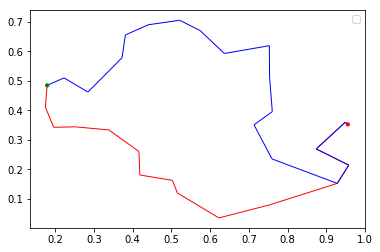

('Dijkstra path :', [8, 44, 4, 58, 16, 68, 3, 57, 64, 2, 84, 22, 70, 14, 42, 20, 12])
('NN path :', [8, 44, 4, 58, 16, 17, 25, 32, 65, 86, 74, 78, 61, 6, 98, 38, 91, 21, 12])



The model is able to find a different path between 27 and 16


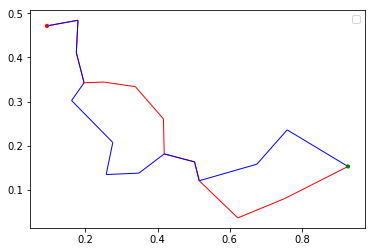

('Dijkstra path :', [27, 12, 20, 42, 14, 70, 22, 84, 2, 64, 57, 3, 68, 16])
('NN path :', [27, 12, 20, 42, 50, 87, 63, 19, 2, 64, 57, 99, 17, 16])

The model is able to find a different path between 64 and 30


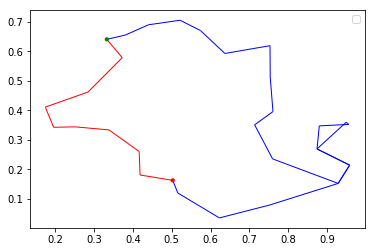

('Dijkstra path :', [64, 2, 84, 22, 70, 14, 42, 20, 91, 38, 30])
('NN path :', [64, 57, 3, 68, 16, 58, 4, 1, 8, 44, 4, 58, 16, 17, 25, 32, 65, 86, 74, 78, 61, 6, 98, 30])

The model is able to find a different path between 45 and 62


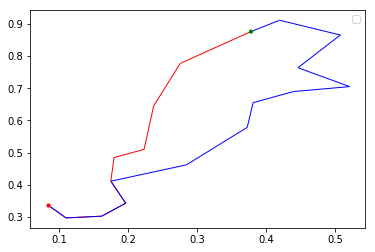

('Dijkstra path :', [45, 95, 50, 42, 20, 12, 21, 71, 59, 62])
('NN path :', [45, 95, 50, 42, 20, 91, 38, 98, 6, 61, 37, 13, 52, 62])

The model is able to find a different path between 68 and 96


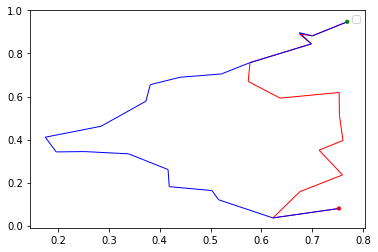

('Dijkstra path :', [68, 3, 99, 17, 25, 32, 65, 86, 74, 78, 80, 82, 35, 33, 96])
('NN path :', [68, 3, 57, 64, 2, 84, 22, 70, 14, 42, 20, 91, 38, 98, 6, 61, 80, 82, 34, 33, 96])

The model is able to find a different path between 80 and 52


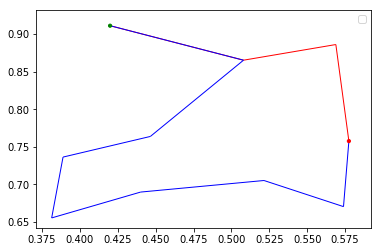

('Dijkstra path :', [80, 51, 13, 52])
('NN path :', [80, 78, 61, 6, 98, 41, 37, 13, 52])

The model is able to find a different path between 51 and 88


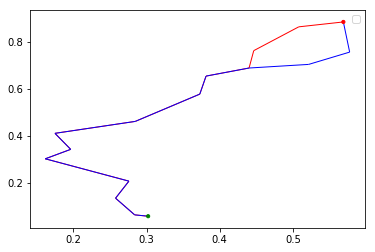

('Dijkstra path :', [51, 13, 37, 6, 98, 38, 91, 20, 42, 50, 87, 63, 18, 88])
('NN path :', [51, 80, 61, 6, 98, 38, 91, 20, 42, 50, 87, 63, 18, 88])

The model is able to find a different path between 15 and 29


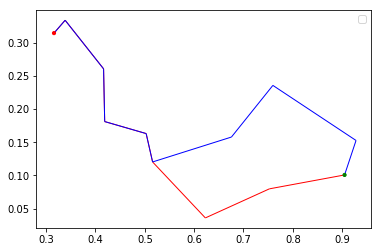

('Dijkstra path :', [15, 22, 84, 2, 64, 57, 3, 68, 29])
('NN path :', [15, 22, 84, 2, 64, 57, 99, 17, 16, 29])

The model is able to find a different path between 11 and 86


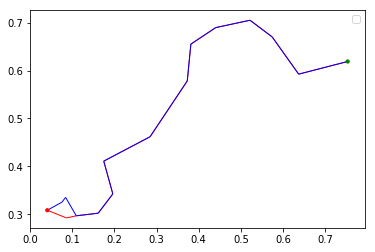

('Dijkstra path :', [11, 54, 95, 50, 42, 20, 91, 38, 98, 6, 61, 78, 74, 86])
('NN path :', [11, 67, 45, 95, 50, 42, 20, 91, 38, 98, 6, 61, 78, 74, 86])



The model is able to find a different path between 49 and 24


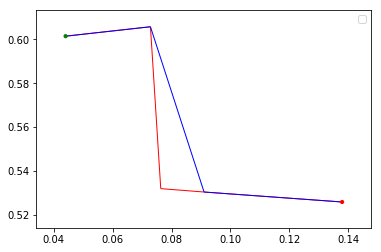

('Dijkstra path :', [49, 66, 36, 46, 24])
('NN path :', [49, 66, 46, 24])

The model is able to find a different path between 50 and 24


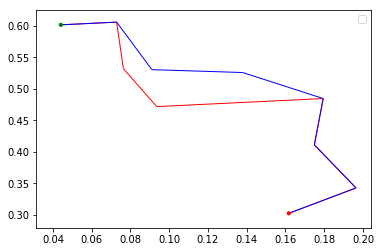

('Dijkstra path :', [50, 42, 20, 12, 27, 36, 46, 24])
('NN path :', [50, 42, 20, 12, 49, 66, 46, 24])

The model is able to find a different path between 73 and 17


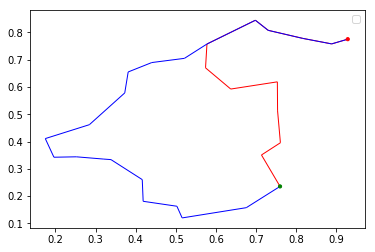

('Dijkstra path :', [73, 60, 43, 81, 82, 80, 78, 74, 86, 65, 32, 25, 17])
('NN path :', [73, 60, 43, 81, 82, 80, 61, 6, 98, 38, 91, 20, 42, 14, 70, 22, 84, 2, 64, 57, 99, 17])



The model is able to find a different path between 24 and 29


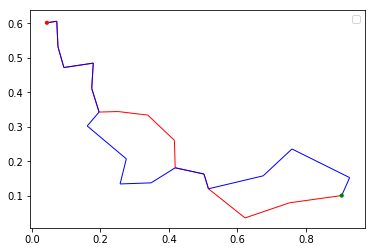

('Dijkstra path :', [24, 46, 36, 27, 12, 20, 42, 14, 70, 22, 84, 2, 64, 57, 3, 68, 29])
('NN path :', [24, 46, 36, 27, 12, 20, 42, 50, 87, 63, 19, 2, 64, 57, 99, 17, 16, 29])

The model is able to find a different path between 82 and 59


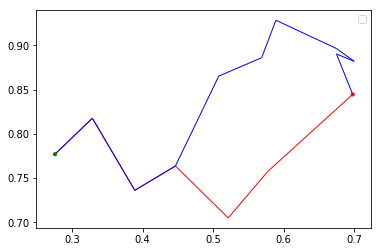

('Dijkstra path :', [82, 80, 61, 37, 41, 69, 59])
('NN path :', [82, 35, 33, 34, 97, 51, 13, 37, 41, 69, 59])

The model is able to find a different path between 0 and 83


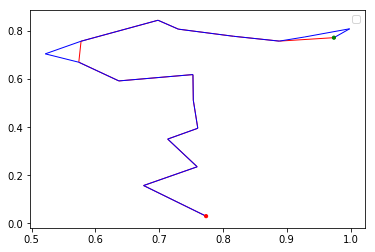

('Dijkstra path :', [0, 99, 17, 25, 32, 65, 86, 74, 78, 80, 82, 81, 43, 60, 83])
('NN path :', [0, 99, 17, 25, 32, 65, 86, 74, 78, 61, 80, 82, 81, 43, 60, 73, 26, 83])

The model is able to find a different path between 52 and 38


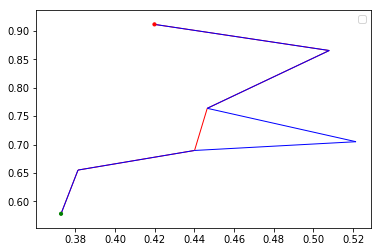

('Dijkstra path :', [52, 13, 37, 6, 98, 38])
('NN path :', [52, 13, 37, 61, 6, 98, 38])

The model is able to find a different path between 98 and 26


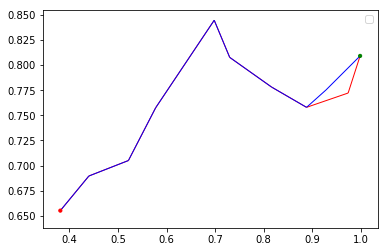

('Dijkstra path :', [98, 6, 61, 80, 82, 81, 43, 60, 83, 26])
('NN path :', [98, 6, 61, 80, 82, 81, 43, 60, 73, 26])



The model is able to find a different path between 47 and 75


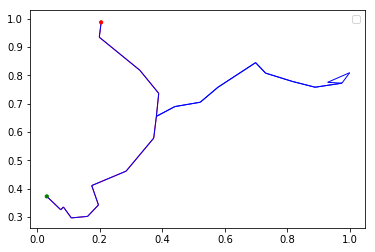

('Dijkstra path :', [47, 79, 69, 41, 98, 38, 91, 20, 42, 50, 95, 45, 67, 75])
('NN path :', [47, 79, 69, 41, 98, 6, 61, 80, 82, 81, 43, 60, 83, 73, 26, 83, 60, 43, 81, 82, 80, 61, 6, 98, 38, 91, 20, 42, 50, 95, 45, 67, 75])



The model is able to find a different path between 52 and 49


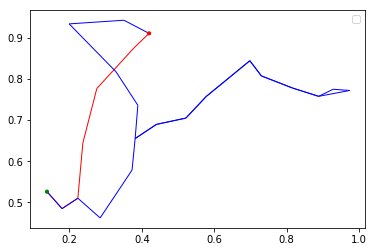

('Dijkstra path :', [52, 62, 59, 71, 21, 12, 49])
('NN path :', [52, 93, 79, 69, 41, 98, 6, 61, 80, 82, 81, 43, 60, 83, 73, 60, 43, 81, 82, 80, 61, 6, 98, 38, 91, 21, 12, 49])



The model is able to find a different path between 96 and 68


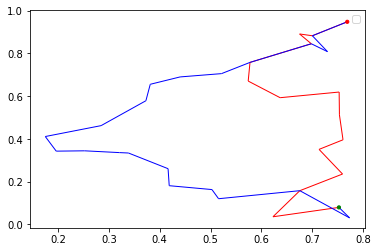

('Dijkstra path :', [96, 33, 35, 82, 80, 78, 74, 86, 65, 32, 25, 17, 99, 3, 68])
('NN path :', [96, 33, 81, 82, 80, 61, 6, 98, 38, 91, 20, 42, 14, 70, 22, 84, 2, 64, 57, 99, 0, 68])

The model is able to find a different path between 25 and 94


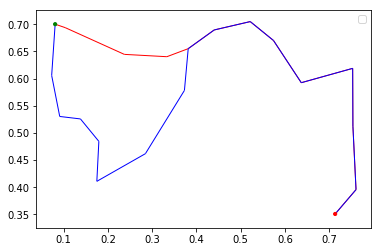

('Dijkstra path :', [25, 32, 65, 86, 74, 78, 61, 6, 98, 30, 71, 28, 94])
('NN path :', [25, 32, 65, 86, 74, 78, 61, 6, 98, 38, 91, 20, 12, 49, 66, 46, 94])

The model is able to find a different path between 99 and 73


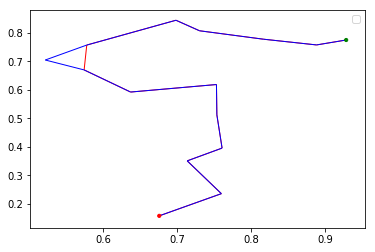

('Dijkstra path :', [99, 17, 25, 32, 65, 86, 74, 78, 80, 82, 81, 43, 60, 73])
('NN path :', [99, 17, 25, 32, 65, 86, 74, 78, 61, 80, 82, 81, 43, 60, 73])

The model is able to find a different path between 15 and 23


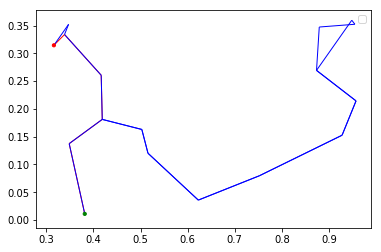

('Dijkstra path :', [15, 22, 84, 2, 19, 23])
('NN path :', [15, 72, 22, 84, 2, 64, 57, 3, 68, 16, 58, 4, 1, 8, 44, 4, 58, 16, 68, 3, 57, 64, 2, 19, 23])

The model is able to find a different path between 24 and 98


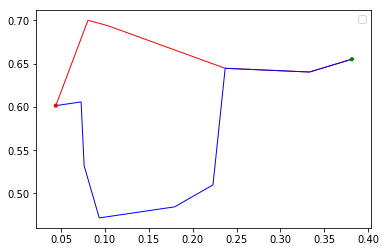

('Dijkstra path :', [24, 94, 28, 71, 30, 98])
('NN path :', [24, 46, 36, 27, 12, 21, 71, 30, 98])

The model is able to find a different path between 92 and 7


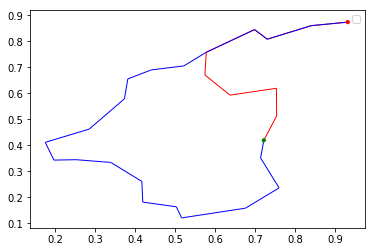

('Dijkstra path :', [92, 9, 81, 82, 80, 78, 74, 86, 65, 7])
('NN path :', [92, 9, 81, 82, 80, 61, 6, 98, 38, 91, 20, 42, 14, 70, 22, 84, 2, 64, 57, 99, 17, 25, 7])



The model is able to find a different path between 94 and 25


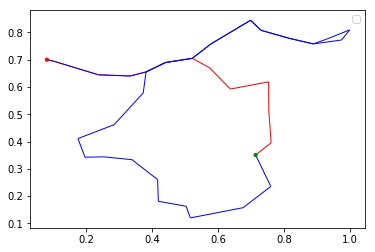

('Dijkstra path :', [94, 28, 71, 30, 98, 6, 61, 78, 74, 86, 65, 32, 25])
('NN path :', [94, 28, 71, 30, 98, 6, 61, 80, 82, 81, 43, 60, 83, 26, 73, 60, 43, 81, 82, 80, 61, 6, 98, 38, 91, 20, 42, 14, 70, 22, 84, 2, 64, 57, 99, 17, 25])



The model is able to find a different path between 66 and 79


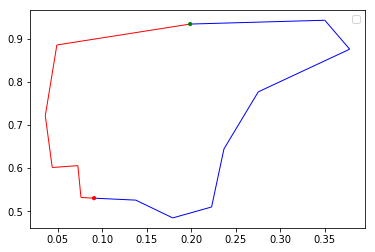

('Dijkstra path :', [66, 36, 46, 24, 10, 39, 79])
('NN path :', [66, 49, 12, 21, 71, 59, 62, 93, 79])

The model is able to find a different path between 91 and 57


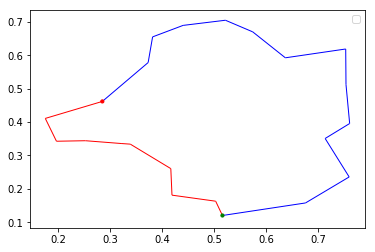

('Dijkstra path :', [91, 20, 42, 14, 70, 22, 84, 2, 64, 57])
('NN path :', [91, 38, 98, 6, 61, 78, 74, 86, 65, 32, 25, 17, 99, 57])



The model is able to find a different path between 60 and 72


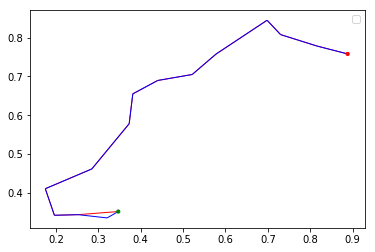

('Dijkstra path :', [60, 43, 81, 82, 80, 61, 6, 98, 38, 91, 20, 42, 14, 72])
('NN path :', [60, 43, 81, 82, 80, 61, 6, 98, 38, 91, 20, 42, 14, 70, 72])



The model is able to find a different path between 69 and 36


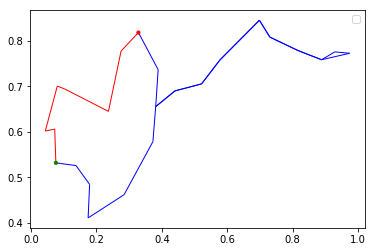

('Dijkstra path :', [69, 59, 71, 28, 94, 24, 46, 36])
('NN path :', [69, 41, 98, 6, 61, 80, 82, 81, 43, 60, 83, 73, 60, 43, 81, 82, 80, 61, 6, 98, 38, 91, 20, 12, 49, 66, 36])

The model is able to find a different path between 57 and 76


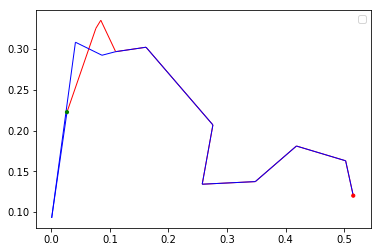

('Dijkstra path :', [57, 64, 2, 19, 63, 87, 50, 95, 45, 67, 76])
('NN path :', [57, 64, 2, 19, 63, 87, 50, 95, 54, 11, 48, 76])



The model is able to find a different path between 62 and 11


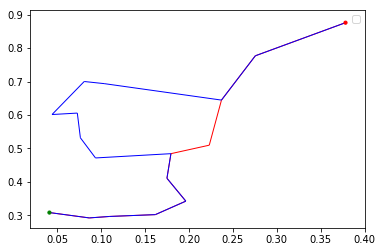

('Dijkstra path :', [62, 59, 71, 21, 12, 20, 42, 50, 95, 54, 11])
('NN path :', [62, 59, 71, 28, 94, 24, 46, 36, 27, 12, 20, 42, 50, 95, 54, 11])

The model is able to find a different path between 44 and 42


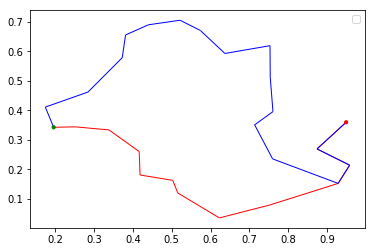

('Dijkstra path :', [44, 4, 58, 16, 68, 3, 57, 64, 2, 84, 22, 70, 14, 42])
('NN path :', [44, 4, 58, 16, 17, 25, 32, 65, 86, 74, 78, 61, 6, 98, 38, 91, 20, 42])



The model is able to find a different path between 7 and 36


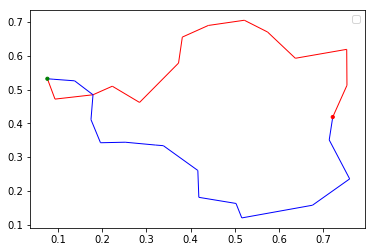

('Dijkstra path :', [7, 65, 86, 74, 78, 61, 6, 98, 38, 91, 21, 12, 27, 36])
('NN path :', [7, 25, 17, 99, 57, 64, 2, 84, 22, 70, 14, 42, 20, 12, 49, 66, 36])



The model is able to find a different path between 58 and 90


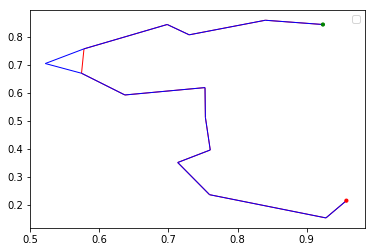

('Dijkstra path :', [58, 16, 17, 25, 32, 65, 86, 74, 78, 80, 82, 81, 9, 90])
('NN path :', [58, 16, 17, 25, 32, 65, 86, 74, 78, 61, 80, 82, 81, 9, 90])



The model is able to find a different path between 1 and 27


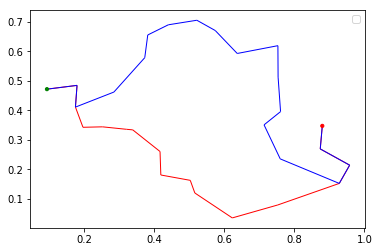

('Dijkstra path :', [1, 4, 58, 16, 68, 3, 57, 64, 2, 84, 22, 70, 14, 42, 20, 12, 27])
('NN path :', [1, 4, 58, 16, 17, 25, 32, 65, 86, 74, 78, 61, 6, 98, 38, 91, 20, 12, 27])



The model is able to find a different path between 97 and 65


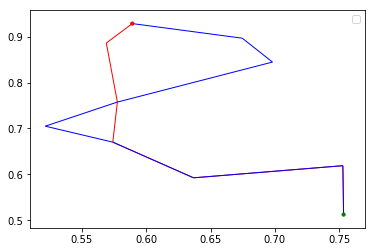

('Dijkstra path :', [97, 51, 80, 78, 74, 86, 65])
('NN path :', [97, 34, 82, 80, 61, 78, 74, 86, 65])

The model is able to find a different path between 79 and 66


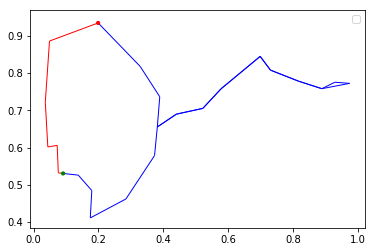

('Dijkstra path :', [79, 39, 10, 24, 46, 36, 66])
('NN path :', [79, 69, 41, 98, 6, 61, 80, 82, 81, 43, 60, 83, 73, 60, 43, 81, 82, 80, 61, 6, 98, 38, 91, 20, 12, 49, 66])



The model is able to find a different path between 47 and 25


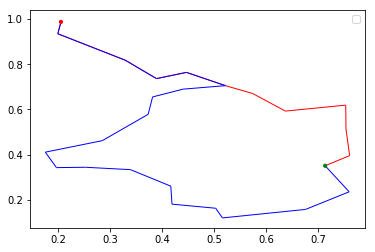

('Dijkstra path :', [47, 79, 69, 41, 37, 61, 78, 74, 86, 65, 32, 25])
('NN path :', [47, 79, 69, 41, 37, 61, 6, 98, 38, 91, 20, 42, 14, 70, 22, 84, 2, 64, 57, 99, 17, 25])

The model is able to find a different path between 76 and 57


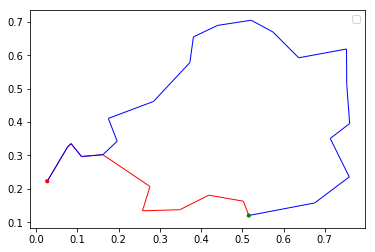

('Dijkstra path :', [76, 67, 45, 95, 50, 87, 63, 19, 2, 64, 57])
('NN path :', [76, 67, 45, 95, 50, 42, 20, 91, 38, 98, 6, 61, 78, 74, 86, 65, 32, 25, 17, 99, 57])



The model is able to find a different path between 57 and 47


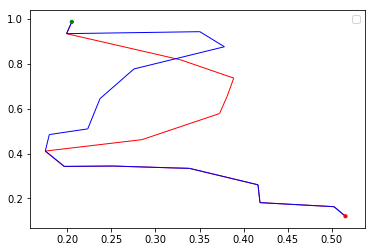

('Dijkstra path :', [57, 64, 2, 84, 22, 70, 14, 42, 20, 91, 38, 98, 41, 69, 79, 47])
('NN path :', [57, 64, 2, 84, 22, 70, 14, 42, 20, 12, 21, 71, 59, 62, 93, 79, 47])

The model is able to find a different path between 78 and 38


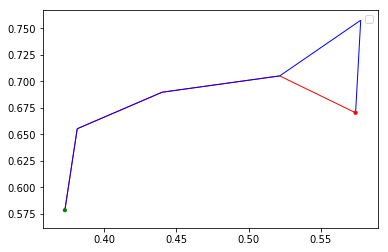

('Dijkstra path :', [78, 61, 6, 98, 38])
('NN path :', [78, 80, 61, 6, 98, 38])



The model is able to find a different path between 68 and 76


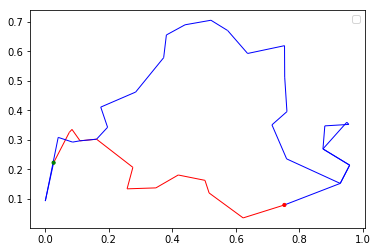

('Dijkstra path :', [68, 3, 57, 64, 2, 19, 63, 87, 50, 95, 45, 67, 76])
('NN path :', [68, 16, 58, 4, 1, 8, 44, 4, 58, 16, 17, 25, 32, 65, 86, 74, 78, 61, 6, 98, 38, 91, 20, 42, 50, 95, 54, 11, 48, 76])

The model is able to find a different path between 85 and 59


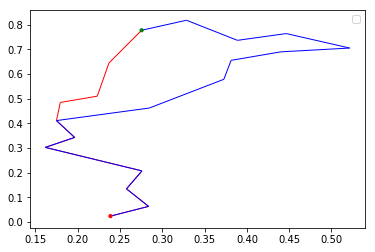

('Dijkstra path :', [85, 18, 63, 87, 50, 42, 20, 12, 21, 71, 59])
('NN path :', [85, 18, 63, 87, 50, 42, 20, 91, 38, 98, 6, 61, 37, 41, 69, 59])



The model is able to find a different path between 41 and 71


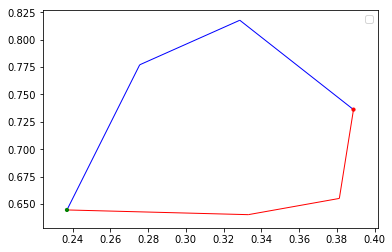

('Dijkstra path :', [41, 98, 30, 71])
('NN path :', [41, 69, 59, 71])

The model is able to find a different path between 21 and 3


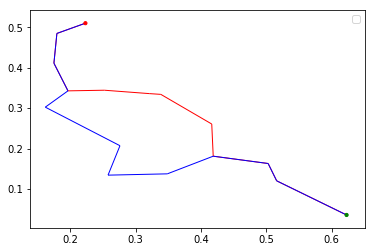

('Dijkstra path :', [21, 12, 20, 42, 14, 70, 22, 84, 2, 64, 57, 3])
('NN path :', [21, 12, 20, 42, 50, 87, 63, 19, 2, 64, 57, 3])

The model is able to find a different path between 52 and 80


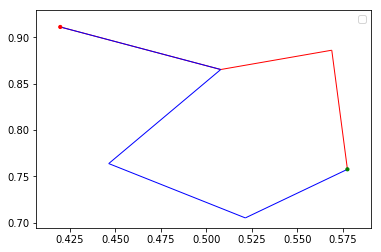

('Dijkstra path :', [52, 13, 51, 80])
('NN path :', [52, 13, 37, 61, 80])



The model is able to find a different path between 79 and 43


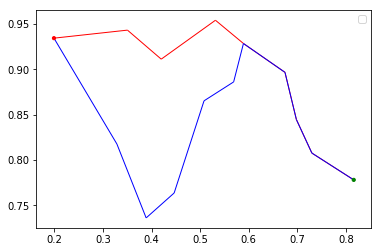

('Dijkstra path :', [79, 93, 52, 55, 97, 34, 82, 81, 43])
('NN path :', [79, 69, 41, 37, 13, 51, 97, 34, 82, 81, 43])

The model is able to find a different path between 19 and 38


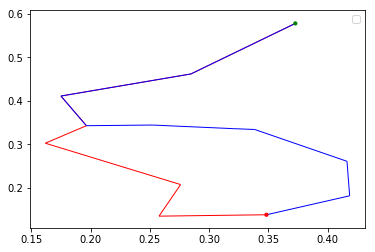

('Dijkstra path :', [19, 63, 87, 50, 42, 20, 91, 38])
('NN path :', [19, 2, 84, 22, 70, 14, 42, 20, 91, 38])



The model is able to find a different path between 52 and 71


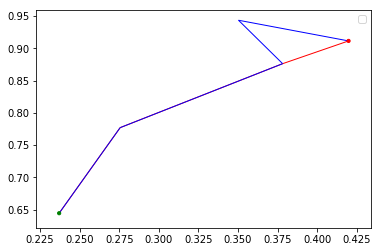

('Dijkstra path :', [52, 62, 59, 71])
('NN path :', [52, 93, 62, 59, 71])



The model is able to find a different path between 43 and 28


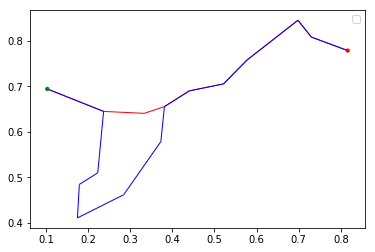

('Dijkstra path :', [43, 81, 82, 80, 61, 6, 98, 30, 71, 28])
('NN path :', [43, 81, 82, 80, 61, 6, 98, 38, 91, 20, 12, 21, 71, 28])



The model is able to find a different path between 78 and 31


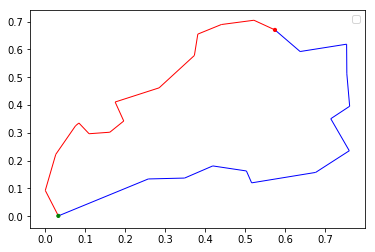

('Dijkstra path :', [78, 61, 6, 98, 38, 91, 20, 42, 50, 95, 45, 67, 76, 48, 31])
('NN path :', [78, 74, 86, 65, 32, 25, 17, 99, 57, 64, 2, 19, 63, 31])



The model is able to find a different path between 4 and 91


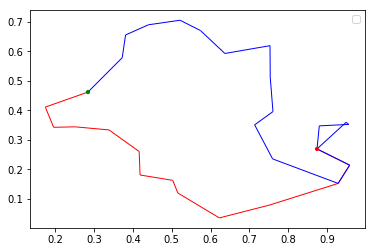

('Dijkstra path :', [4, 58, 16, 68, 3, 57, 64, 2, 84, 22, 70, 14, 42, 20, 91])
('NN path :', [4, 44, 8, 1, 4, 58, 16, 17, 25, 32, 65, 86, 74, 78, 61, 6, 98, 38, 91])

355 out of 400 can find path: 0.887500
177 out of 355 can find optimal path: 0.498592
177 out of 400 all paths can find optimal paths: 0.442500
355 pairs, μ=0.876192, σ=0.221071
355 pairs, μ=0.864990, σ=0.203292


In [34]:
num_node_pairs = 400

_, _, G_test, pair_path_dict = generate_samples_from_graph(num_node_pairs=num_node_pairs, graph_size=100, augmentation=False, label='Test')
print_paths_statistics(G_test, num_to_test=num_node_pairs, pair_path_dict=pair_path_dict)

In [33]:
def plot_dijkstra_nn_comparison(G, dijkstra_node_list, nn_node_list):

    pos = {}

    for node in dijkstra_node_list:
        pos[node] = (G.nodes[node]['x'], G.nodes[node]['y'])

    dijkstra_edge_list = []
    for idx, node in enumerate(dijkstra_node_list[:-1]):
        dijkstra_edge_list.append((node, dijkstra_node_list[idx+1]))

    nx.draw_networkx_edges(G, pos=pos, edgelist=dijkstra_edge_list, node_size=20, edge_color='r')
    nn_pos = {}

    for node in nn_node_list:
        nn_pos[node] = (G.nodes[node]['x'], G.nodes[node]['y'])

    nn_edge_list = []
    for idx, node in enumerate(nn_node_list[:-1]):
        nn_edge_list.append((node, nn_node_list[idx+1]))

    nx.draw_networkx_edges(G, pos=nn_pos, edgelist=set(nn_edge_list), node_size=100, edge_color='b')
    
    nx.draw_networkx_nodes(G, pos=pos,\
                           nodelist=[dijkstra_node_list[0], dijkstra_node_list[-1]],\
                           node_size=10,\
                           node_color=['r', 'g'])
    
    plt.legend(loc='best')
    plt.show()

# Some Analysis

It seems that in the cases where the model fails to find a path, the model is trapped in a dead loop; however, at the early stage of inference, the generated path is not absolute
nonsense. At some point, the model makes a dubious turn and the paths are likely to diverge.

The model has learned, to some extent, to crawl its way back to where it made a mistake and
make it to the destination; 

this is understandable since the training set sampling is bidirectional; 
more specifically, whenever a pair of nodes are selected, the paths from 
both directions are calculated and recorded; this provides the model with
the information about how to get back when the current path chosen is too
wrong.

# Shortest Path Strategy + Exploration

We investigate how the paths are affected by the added exploration
strategy. Stated differently, an agene is both exploiting with learned shortest path strategy and exploring random nodes by probability $p$. This means the agent will follow it prediction
with probability $1-p$.

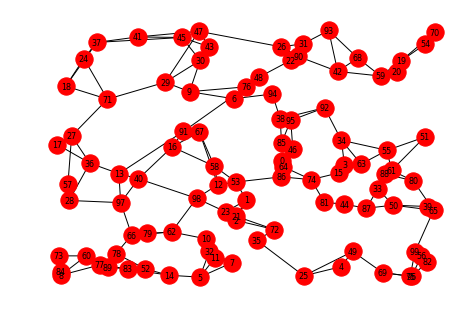

In [35]:
G = generate_low_degree_g()
plot_g(G)

In [44]:
def sample_node_pairs(num_node_pairs, num_of_nodes):
    
    pair_path_dict = dict()
    
    while True:
        
        if len(pair_path_dict) >= num_node_pairs:
            break
        
        src = np.random.randint(0, num_of_nodes)
        dst = np.random.randint(0, num_of_nodes)
        
        if src == dst or (src, dst) in pair_path_dict or not nx.has_path(G, src, dst):
            continue
            
        pair_path_dict[(src, dst)] = []
        pair_path_dict[(dst, src)] = []
        
    return pair_path_dict

pair_path_dict = sample_node_pairs(200, G.number_of_nodes())

In [45]:
p_group = [0.75, 0.5, 0.25, 0.0]

arrival_rate = [[] for _ in range(len(p_group))]
edge_efficiency_groups = [[] for _ in range(len(p_group))]
time_efficiency_groups = [[] for _ in range(len(p_group))]

model = load_model("mymodel", 10, train_iter, context=mx.cpu())

for idx_p_group, p in enumerate(p_group):
    
    print("Working on %f group" % p)
    
    for i in range(50):
        
        if i > 0 and i % 10 == 0:
            print("Repeated %d times" % i)
            
        cnt = 0
        edge_efficiency = []
        time_efficiency = []
        
        for idx, pair in enumerate(pair_path_dict):
                
            src, dst = pair[0], pair[1]
            path, total_weight, found = dijkstra_path_finder(G, src, dst, p=p, model=model)

            if not found:
                continue
                
            cnt += 1
            assert total_weight == calc_path_weight_sum(G, path)
            dijkstra_path = nx.dijkstra_path(G, src, dst)
            
            edge_efficiency.append(float(len(dijkstra_path)-1) / (len(path)-1))
            time_efficiency.append(calc_path_weight_sum(G, dijkstra_path) \
                                        / total_weight)

        arrival_rate[idx_p_group].append(float(cnt)/len(pair_path_dict))
        
        edge_efficiency_groups[idx_p_group].append(edge_efficiency)
        
        time_efficiency_groups[idx_p_group].append(time_efficiency)
        

Working on 0.750000 group
Repeated 10 times
Repeated 20 times
Repeated 30 times
Repeated 40 times
Working on 0.500000 group
Repeated 10 times
Repeated 20 times
Repeated 30 times
Repeated 40 times
Working on 0.250000 group
Repeated 10 times
Repeated 20 times
Repeated 30 times
Repeated 40 times
Working on 0.000000 group
Repeated 10 times
Repeated 20 times
Repeated 30 times
Repeated 40 times


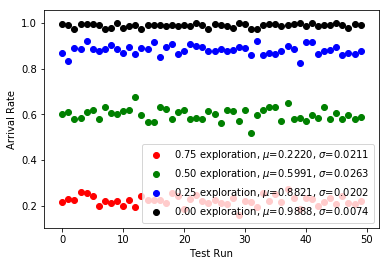

In [48]:
colors = ['r', 'g', 'b', 'k']

for idx, rate in enumerate(arrival_rate):
    stat_mean = np.mean(rate)
    stat_std = np.std(rate)
    label = u'%0.2f exploration, $\mu$=%0.4f, $\sigma$=%0.4f' % \
            (p_group[idx], stat_mean, stat_std)
    
    plt.scatter(list(range(50)), rate, label=label, c=colors[idx])

plt.ylabel("Arrival Rate")
plt.xlabel("Test Run")
plt.legend(loc='lower right')
plt.show()

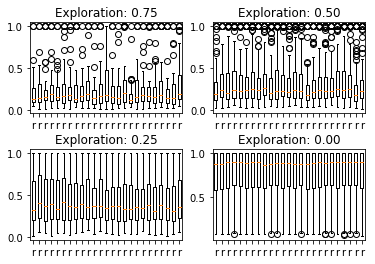

In [53]:

f, axarr = plt.subplots(2, 2)

for i in range(4):
    random.shuffle(time_efficiency_groups[i])
    axarr[int(i/2), i%2].boxplot(time_efficiency_groups[i][:25], labels=['r'] * 25)
    axarr[int(i/2), i%2].set_title("Exploration: %0.2f"% p_group[i])

f.subplots_adjust(hspace=0.4)
plt.show()


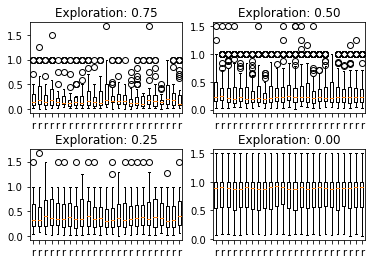

In [54]:

f, axarr = plt.subplots(2, 2)

for i in range(4):
    random.shuffle(edge_efficiency_groups[i])
    axarr[int(i/2), i%2].boxplot(edge_efficiency_groups[i][:25], labels=['r'] * 25)
    axarr[int(i/2), i%2].set_title("Exploration: %0.2f"% p_group[i])

f.subplots_adjust(hspace=0.4)
plt.show()


In [60]:
(time_efficiency_groups[3][-1])

[0.75737017926834482,
 1.0,
 1.0,
 0.29432986466853028,
 1.0,
 0.47839654475332011,
 0.34067092728118586,
 0.35518314267700007,
 1.0,
 0.28633310463761974,
 0.72734448089088533,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.13245256678643666,
 0.59846093886231977,
 0.31039268681749382,
 0.91786368835059218,
 0.84671165753758404,
 1.0,
 0.76030809656110343,
 0.79885014903129814,
 1.0,
 0.89951475758882626,
 0.51888105007398866,
 1.0,
 1.0,
 0.58132129120774134,
 0.67042100086012935,
 0.63500615780452951,
 0.22572194200003801,
 1.0,
 1.0,
 0.45359528731572002,
 0.56112031304569632,
 0.93067247285526145,
 0.98608308017964352,
 1.0,
 0.82006945840255241,
 1.0,
 0.53917851642829273,
 0.5762925122362671,
 1.0,
 1.0,
 0.86767567031377002,
 1.0,
 0.80841833417342468,
 1.0,
 1.0,
 0.6096869440240934,
 0.15466375086887071,
 0.95494436202245014,
 1.0,
 0.51007097322266759,
 1.0,
 1.0,
 0.29278453289809342,
 1.0,
 0.95950785660369375,
 0.73354587606330168,
 1.0,
 0.91385593084360239,
 1.0,
 1

In [61]:
?plt.boxplot